In [444]:
import platform
from pathlib import Path
from datetime import datetime, timedelta
import datajoint as dj
dj.blob.use_32bit_dims = True # necessary for pd.blob read

from create_trials_df import create_trials_df_from_dj
from create_days_df import create_days_df_from_dj, lazy_load_days_summary_df

from multiplot_summaries import *

import plot_utils as pu
import dj_utils as dju
import dir_utils as du

from plot_trials_info import *
from plot_days_info import *

# settings
%load_ext autoreload
%autoreload 2
sns.set_context("talk")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## TRIALS PLOTS

In [ ]:
tdf = create_trials_df_from_dj(
    animal_ids=["R029"], date_min="2023-12-19", date_max="2023-12-19"
)

fetched 1 sessions for R029 between 2023-12-19 and 2023-12-19


In [395]:
def calculate_sliding_window_average(df):
    # Initialize a column to store the sliding window average
    df["sliding_avg"] = np.nan

    # Iterate over each unique block type
    for block_type in df["pro_anti_block_type"].unique():
        block_indices = df[df["pro_anti_block_type"] == block_type].index

        # Apply rolling window calculation for each block
        for start_idx in block_indices:
            end_idx = start_idx + 20  # Define the window end index
            window = df.loc[start_idx:end_idx, "hits"]  # Extract the window
            df.loc[start_idx, "sliding_avg"] = window.mean()  # Calculate the average

    return df[["sliding_avg", "trial", "hits", "pro_anti_block_type"]].copy()

In [409]:
xx = calculate_sliding_window_average(tdf)


def cumulative_hit_rate(block):
    # Replace None with NaN for proper calculations
    block = block.replace({None: pd.NA})
    # Calculate cumulative sum and count, respecting the maximum window size of 20
    cumsum = (
        block["hits"]
        .expanding(min_periods=1)
        .apply(lambda x: x.tail(min(20, len(x))).sum(), raw=True)
    )
    count = (
        block["hits"]
        .expanding(min_periods=1)
        .apply(lambda x: x.tail(min(20, len(x))).count(), raw=True)
    )
    return cumsum / count

In [414]:
tdf.groupby("n_blocks")["hits"].head()

0      1
1      1
2      1
3      1
4      1
      ..
368    1
369    1
370    1
371    0
372    1
Name: hits, Length: 85, dtype: uint64[pyarrow]

In [422]:
def cumulative_hit_rate(group):
    # Replace None with NaN for proper calculations
    group["hits"] = group["hits"].replace({None: pd.NA})
    # Calculate cumulative sum and count, respecting the maximum window size of 20
    cumsum = (
        group["hits"]
        .expanding(min_periods=1)
        .apply(lambda x: np.nansum(x[-20:]), raw=True)
    )
    count = (
        group["hits"]
        .expanding(min_periods=1)
        .apply(lambda x: np.count_nonzero(~np.isnan(x[-20:])), raw=True)
    )
    group["cumulative_hit_rate"] = cumsum / count
    return group


# Apply the function to each block, grouped by 'n_blocks'
tdf.groupby("n_blocks").apply(cumulative_hit_rate).reset_index(drop=True)

trial animal_id        date sess_id  result  hits  violations  temperror   
0        1      R029  2023-12-19  941133       1     1           0          0  \
1        2      R029  2023-12-19  941133       1     1           0          0   
2        3      R029  2023-12-19  941133       1     1           0          0   
3        4      R029  2023-12-19  941133       1     1           0          0   
4        5      R029  2023-12-19  941133       1     1           0          0   
..     ...       ...         ...     ...     ...   ...         ...        ...   
370    371      R029  2023-12-19  941133       1     1           0          0   
371    372      R029  2023-12-19  941133       2     0           0          0   
372    373      R029  2023-12-19  941133       1     1           0          0   
373    374      R029  2023-12-19  941133       1     1           0          0   
374    375      R029  2023-12-19  941133       1     1           0          0   

     hit_rate  error_rate  ...  ab_tau  exp_del_tau  exp_del_min  exp_del_max   
0        0.00        0.00  ...    30.0          0.2          0.1          0.6  \
1        1.00        0.00  ...    30.0          0.2          0.1          0.6   
2        1.00        0.00  ...    30.0          0.2          0.1          0.6   
3        1.00        0.00  ...    30.0          0.2          0.1          0.6   
4        1.00        0.00  ...    30.0          0.2          0.1          0.6   
..        ...         ...  ...     ...          ...          ...          ...   
370      0.77        0.23  ...    30.0          0.2          0.1          0.6   
371      0.77        0.23  ...    30.0          0.2          0.1          0.6   
372      0.77        0.23  ...    30.0          0.2          0.1          0.6   
373      0.77        0.23  ...    30.0          0.2          0.1          0.6   
374      0.77        0.23  ...    30.0          0.2          0.1          0.6   

     sound_pair  min_time_to_spoke  cumulative_give_use give_use_rate   
0     3.0, 12.0             2.0213                    0      0.000000  \
1     3.0, 12.0             2.1765                    0      0.000000   
2      3.0, 3.0             1.7466                    0      0.000000   
3     3.0, 12.0             2.1940                    0      0.000000   
4     3.0, 12.0             2.1456                    0      0.000000   
..          ...                ...                  ...           ...   
370    3.0, 3.0             1.8785                  122      0.328841   
371    3.0, 3.0             2.2589                  122      0.327957   
372    3.0, 3.0             1.9091                  122      0.327078   
373   3.0, 12.0             2.3227                  122      0.326203   
374    3.0, 3.0             1.8266                  122      0.325333   

    sliding_avg  cumulative_hit_rate  
0      0.900000             1.000000  
1      0.900000             1.000000  
2      0.900000             1.000000  
3      0.900000             1.000000  
4      0.894737             1.000000  
..          ...                  ...  
370    0.800000             1.000000  
371    0.750000             0.750000  
372    1.000000             0.800000  
373    1.000000             0.833333  
374    1.000000             0.857143  

[375 rows x 87 columns]

ArrowInvalid: Array type didn't match type of values set: string vs null

In [427]:
ax.plot?

Signature: ax.plot(*args, scalex=True, scaley=True, data=None, **kwargs)
Docstring:
Plot y versus x as lines and/or markers.

Call signatures::

    plot([x], y, [fmt], *, data=None, **kwargs)
    plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)

The coordinates of the points or line nodes are given by *x*, *y*.

The optional parameter *fmt* is a convenient way for defining basic
formatting like color, marker and linestyle. It's a shortcut string
notation described in the *Notes* section below.

>>> plot(x, y)        # plot x and y using default line style and color
>>> plot(x, y, 'bo')  # plot x and y using blue circle markers
>>> plot(y)           # plot y using x as index array 0..N-1
>>> plot(y, 'r+')     # ditto, but with red plusses

You can use `.Line2D` properties as keyword arguments for more
control on the appearance. Line properties and *fmt* can be mixed.
The following two calls yield identical results:

>>> plot(x, y, 'go--', linewidth=2, markersize=12)
>>> plot(x, y, 

<Axes: xlabel='trial', ylabel='cumulative_hit_rate'>

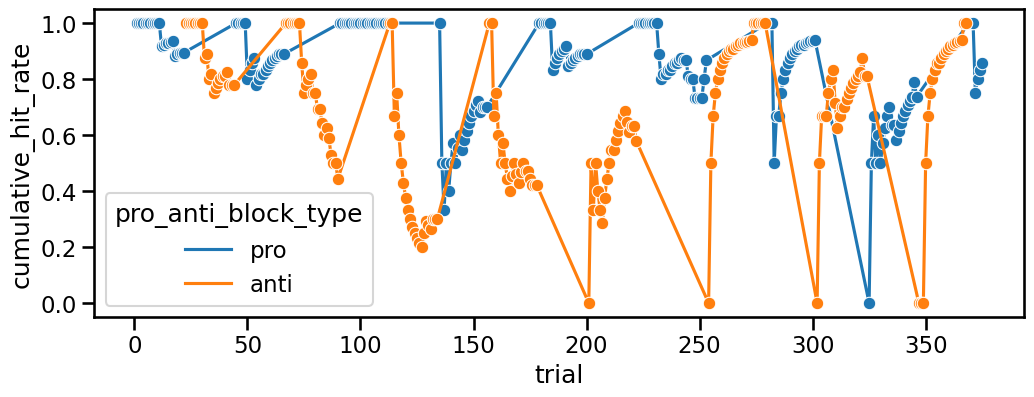

In [434]:
_, ax = pu.make_fig()
sns.lineplot(
    data=tdf,
    x="trial",
    y="cumulative_hit_rate",
    hue="pro_anti_block_type",
    marker="o",
    ax=ax,
)

In [448]:
def rolling_avg(group, window_size):
    group[f"rolling_avg_{window_size}"] = (
        group["hits"].rolling(window=window_size, min_periods=1).mean()
    )
    return group


# Specify your desired window size
window_size = 20

# Group by 'pro_anti_block_type' and apply the rolling average function with the window sizetdf =
(
    tdf.groupby("pro_anti_block_type")
    .apply(rolling_avg, window_size=window_size)
    .reset_index(drop=True)
)

trial animal_id        date sess_id  result  hits  violations  temperror   
0       23      R029  2023-12-19  941133       1     1           0          0  \
1       24      R029  2023-12-19  941133       1     1           0          0   
2       25      R029  2023-12-19  941133       3  <NA>           1       <NA>   
3       26      R029  2023-12-19  941133       1     1           0          0   
4       27      R029  2023-12-19  941133       1     1           0          0   
..     ...       ...         ...     ...     ...   ...         ...        ...   
370    371      R029  2023-12-19  941133       1     1           0          0   
371    372      R029  2023-12-19  941133       2     0           0          0   
372    373      R029  2023-12-19  941133       1     1           0          0   
373    374      R029  2023-12-19  941133       1     1           0          0   
374    375      R029  2023-12-19  941133       1     1           0          0   

     hit_rate  error_rate  ...  exp_del_tau  exp_del_min  exp_del_max   
0        0.90        0.10  ...          0.2          0.1          0.6  \
1        0.91        0.09  ...          0.2          0.1          0.6   
2        0.91        0.09  ...          0.2          0.1          0.6   
3        0.91        0.09  ...          0.2          0.1          0.6   
4        0.92        0.08  ...          0.2          0.1          0.6   
..        ...         ...  ...          ...          ...          ...   
370      0.77        0.23  ...          0.2          0.1          0.6   
371      0.77        0.23  ...          0.2          0.1          0.6   
372      0.77        0.23  ...          0.2          0.1          0.6   
373      0.77        0.23  ...          0.2          0.1          0.6   
374      0.77        0.23  ...          0.2          0.1          0.6   

     sound_pair  min_time_to_spoke  cumulative_give_use  give_use_rate   
0    12.0, 12.0             1.9669                    0       0.000000  \
1     12.0, 3.0             2.1310                    1       0.041667   
2     12.0, 3.0                NaN                    1       0.040000   
3    12.0, 12.0             2.4669                    2       0.076923   
4    12.0, 12.0             2.2735                    3       0.111111   
..          ...                ...                  ...            ...   
370    3.0, 3.0             1.8785                  122       0.328841   
371    3.0, 3.0             2.2589                  122       0.327957   
372    3.0, 3.0             1.9091                  122       0.327078   
373   3.0, 12.0             2.3227                  122       0.326203   
374    3.0, 3.0             1.8266                  122       0.325333   

    sliding_avg cumulative_hit_rate  rolling_avg_20  
0      0.789474            1.000000        1.000000  
1      0.789474            1.000000        1.000000  
2      0.789474            1.000000        1.000000  
3      0.800000            1.000000        1.000000  
4      0.800000            1.000000        1.000000  
..          ...                 ...             ...  
370    0.800000            1.000000        0.789474  
371    0.750000            0.750000        0.789474  
372    1.000000            0.800000        0.789474  
373    1.000000            0.833333        0.789474  
374    1.000000            0.857143        0.789474  

[375 rows x 88 columns]

In [463]:
sns.color_palette("husl", 2)[1]

(0.21044753832183283, 0.6773105080456748, 0.6433941168468681)

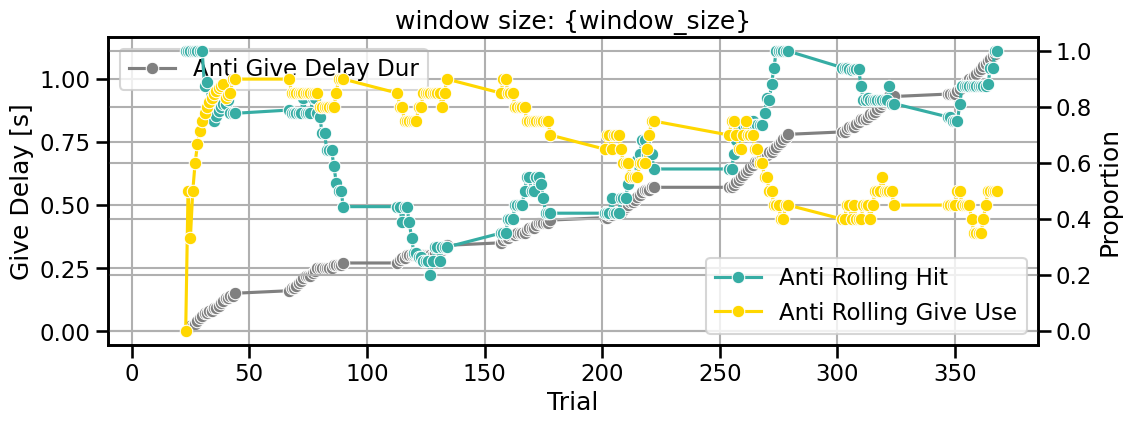

In [471]:
plot_anti_give_del_metrics(tdf)

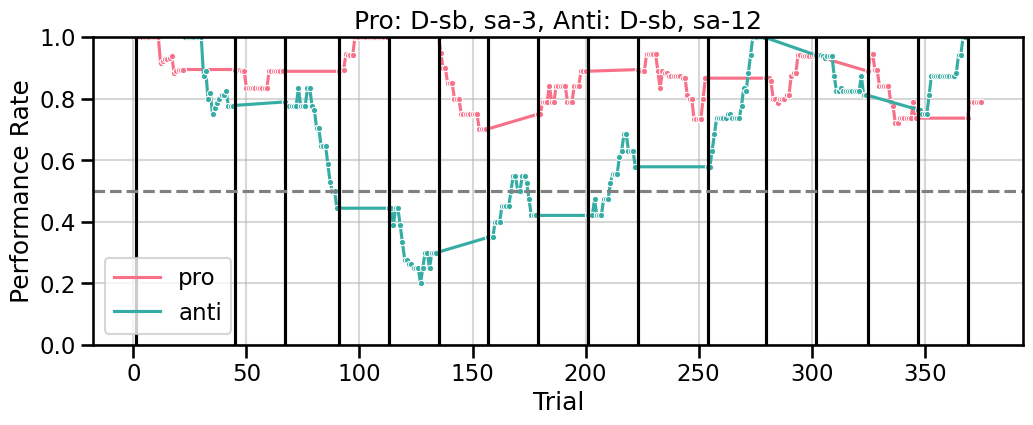

In [466]:
fig, ax = pu.make_fig()
plot_rolling_hit_rate_by_pro_anti(tdf, ax=ax)

In [443]:
tdf.block_size.min()

20.0

<Axes: xlabel='trial', ylabel='rolling_avg_20'>

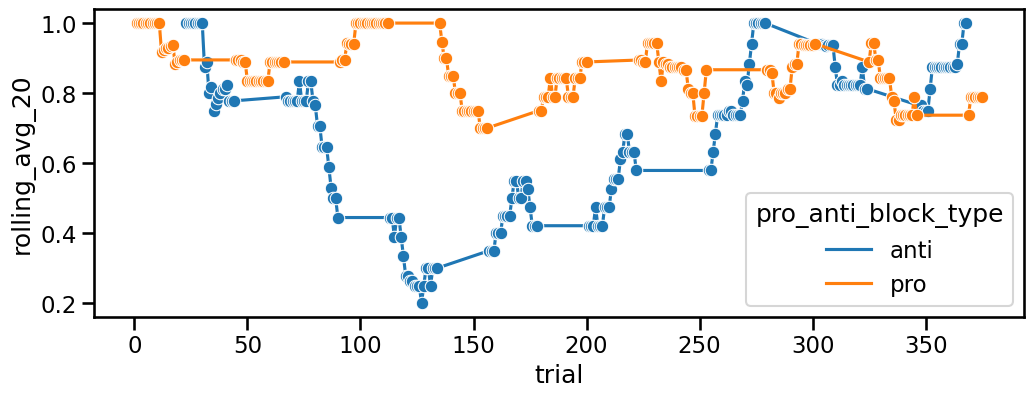

In [442]:
_, ax = pu.make_fig()
sns.lineplot(
    data=tdf,
    x="trial",
    y="rolling_avg_20",
    hue="pro_anti_block_type",
    marker="o",
    ax=ax,
)

<Axes: xlabel='trial', ylabel='give_delay_dur'>

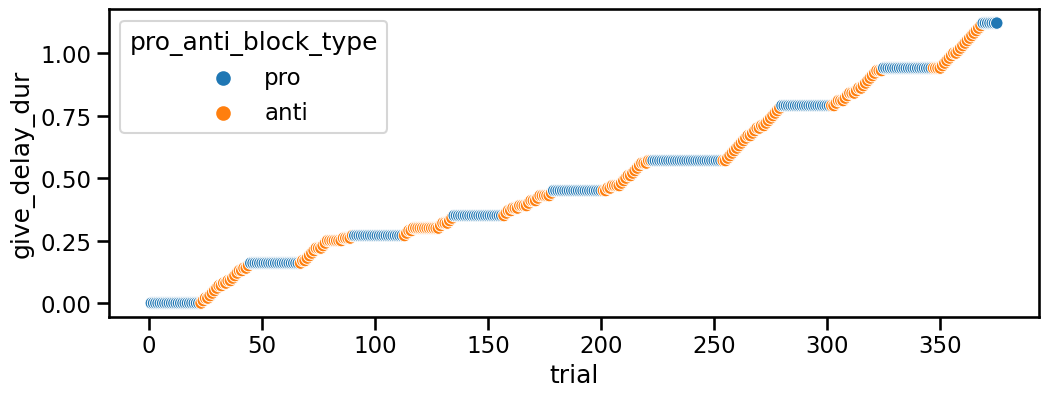

In [8]:
fig, ax = pu.make_fig()

sns.scatterplot(
    data=tdf, x="trial", y="give_delay_dur", hue="pro_anti_block_type", marker="o"
)

<Axes: xlabel='trial', ylabel='give_delay_dur'>

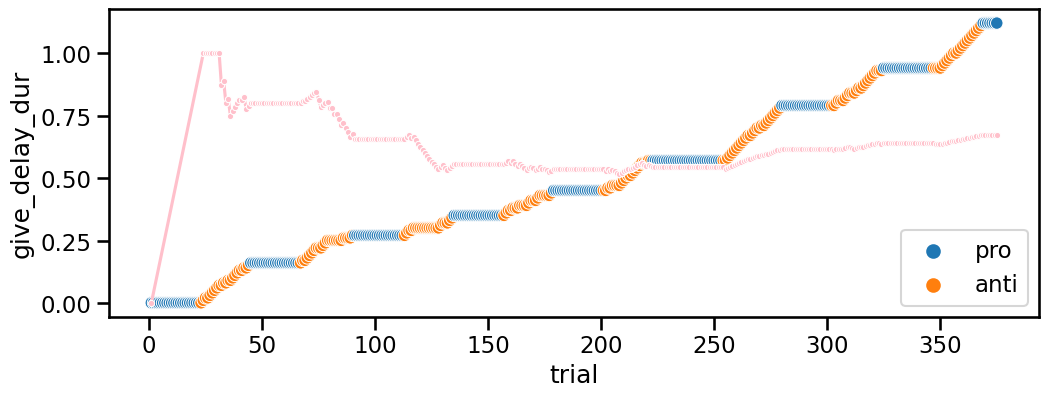

In [14]:
fig, ax = pu.make_fig()

sns.scatterplot(
    data=tdf, x="trial", y="give_delay_dur", hue="pro_anti_block_type", marker="o"
)

sns.lineplot(data=tdf, x="trial", y="anti_hit_rate", marker=".", color="pink")

<Axes: xlabel='trial', ylabel='give_delay_dur'>

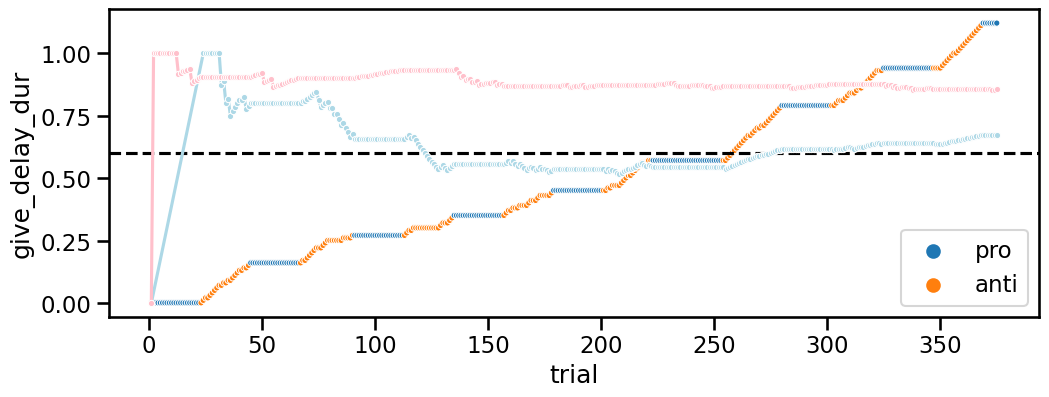

In [39]:
fig, ax = pu.make_fig()
ax.axhline(0.6, color="k", linestyle="--")
sns.scatterplot(
    data=tdf, x="trial", y="give_delay_dur", hue="pro_anti_block_type", marker="."
)

sns.lineplot(data=tdf, x="trial", y="anti_hit_rate", marker=".", color="lightblue")
sns.lineplot(data=tdf, x="trial", y="pro_hit_rate", marker=".", color="pink")

<Axes: xlabel='trial', ylabel='give_delay_dur'>

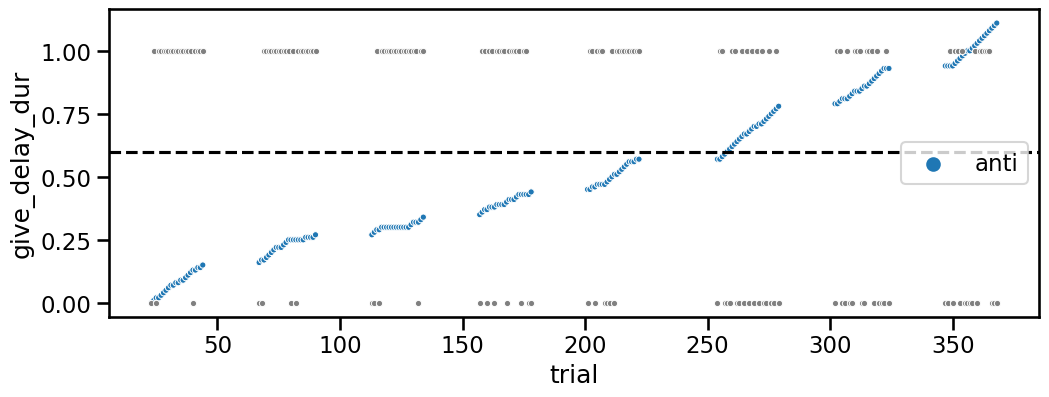

In [190]:
fig, ax = pu.make_fig()
ax.axhline(0.6, color="k", linestyle="--")
sns.scatterplot(
    data=tdf.query("pro_anti_block_type == 'anti'"),
    x="trial",
    y="give_delay_dur",
    hue="pro_anti_block_type",
    marker=".",
)

sns.scatterplot(
    data=tdf.query("pro_anti_block_type == 'anti'"),
    x="trial",
    y="give_use",
    marker=".",
    color="gray",
)

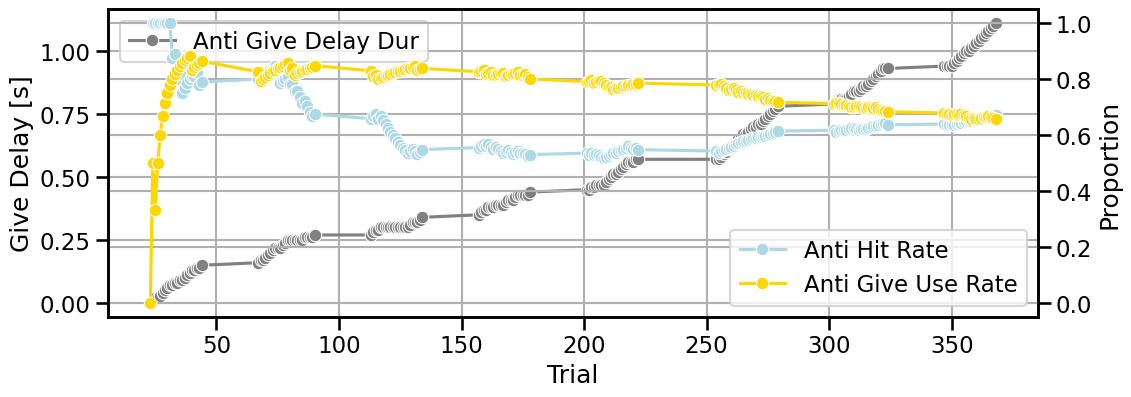

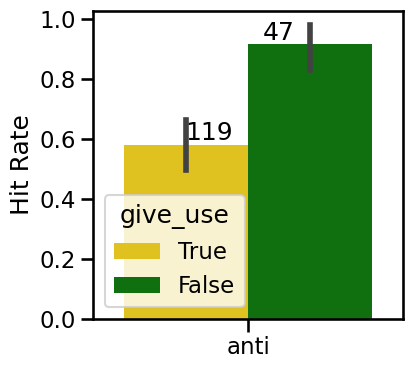

In [191]:
plot_anti_hit_rate_by_give_use(tdf)

['s_a', 's_b', 'post', 'go']


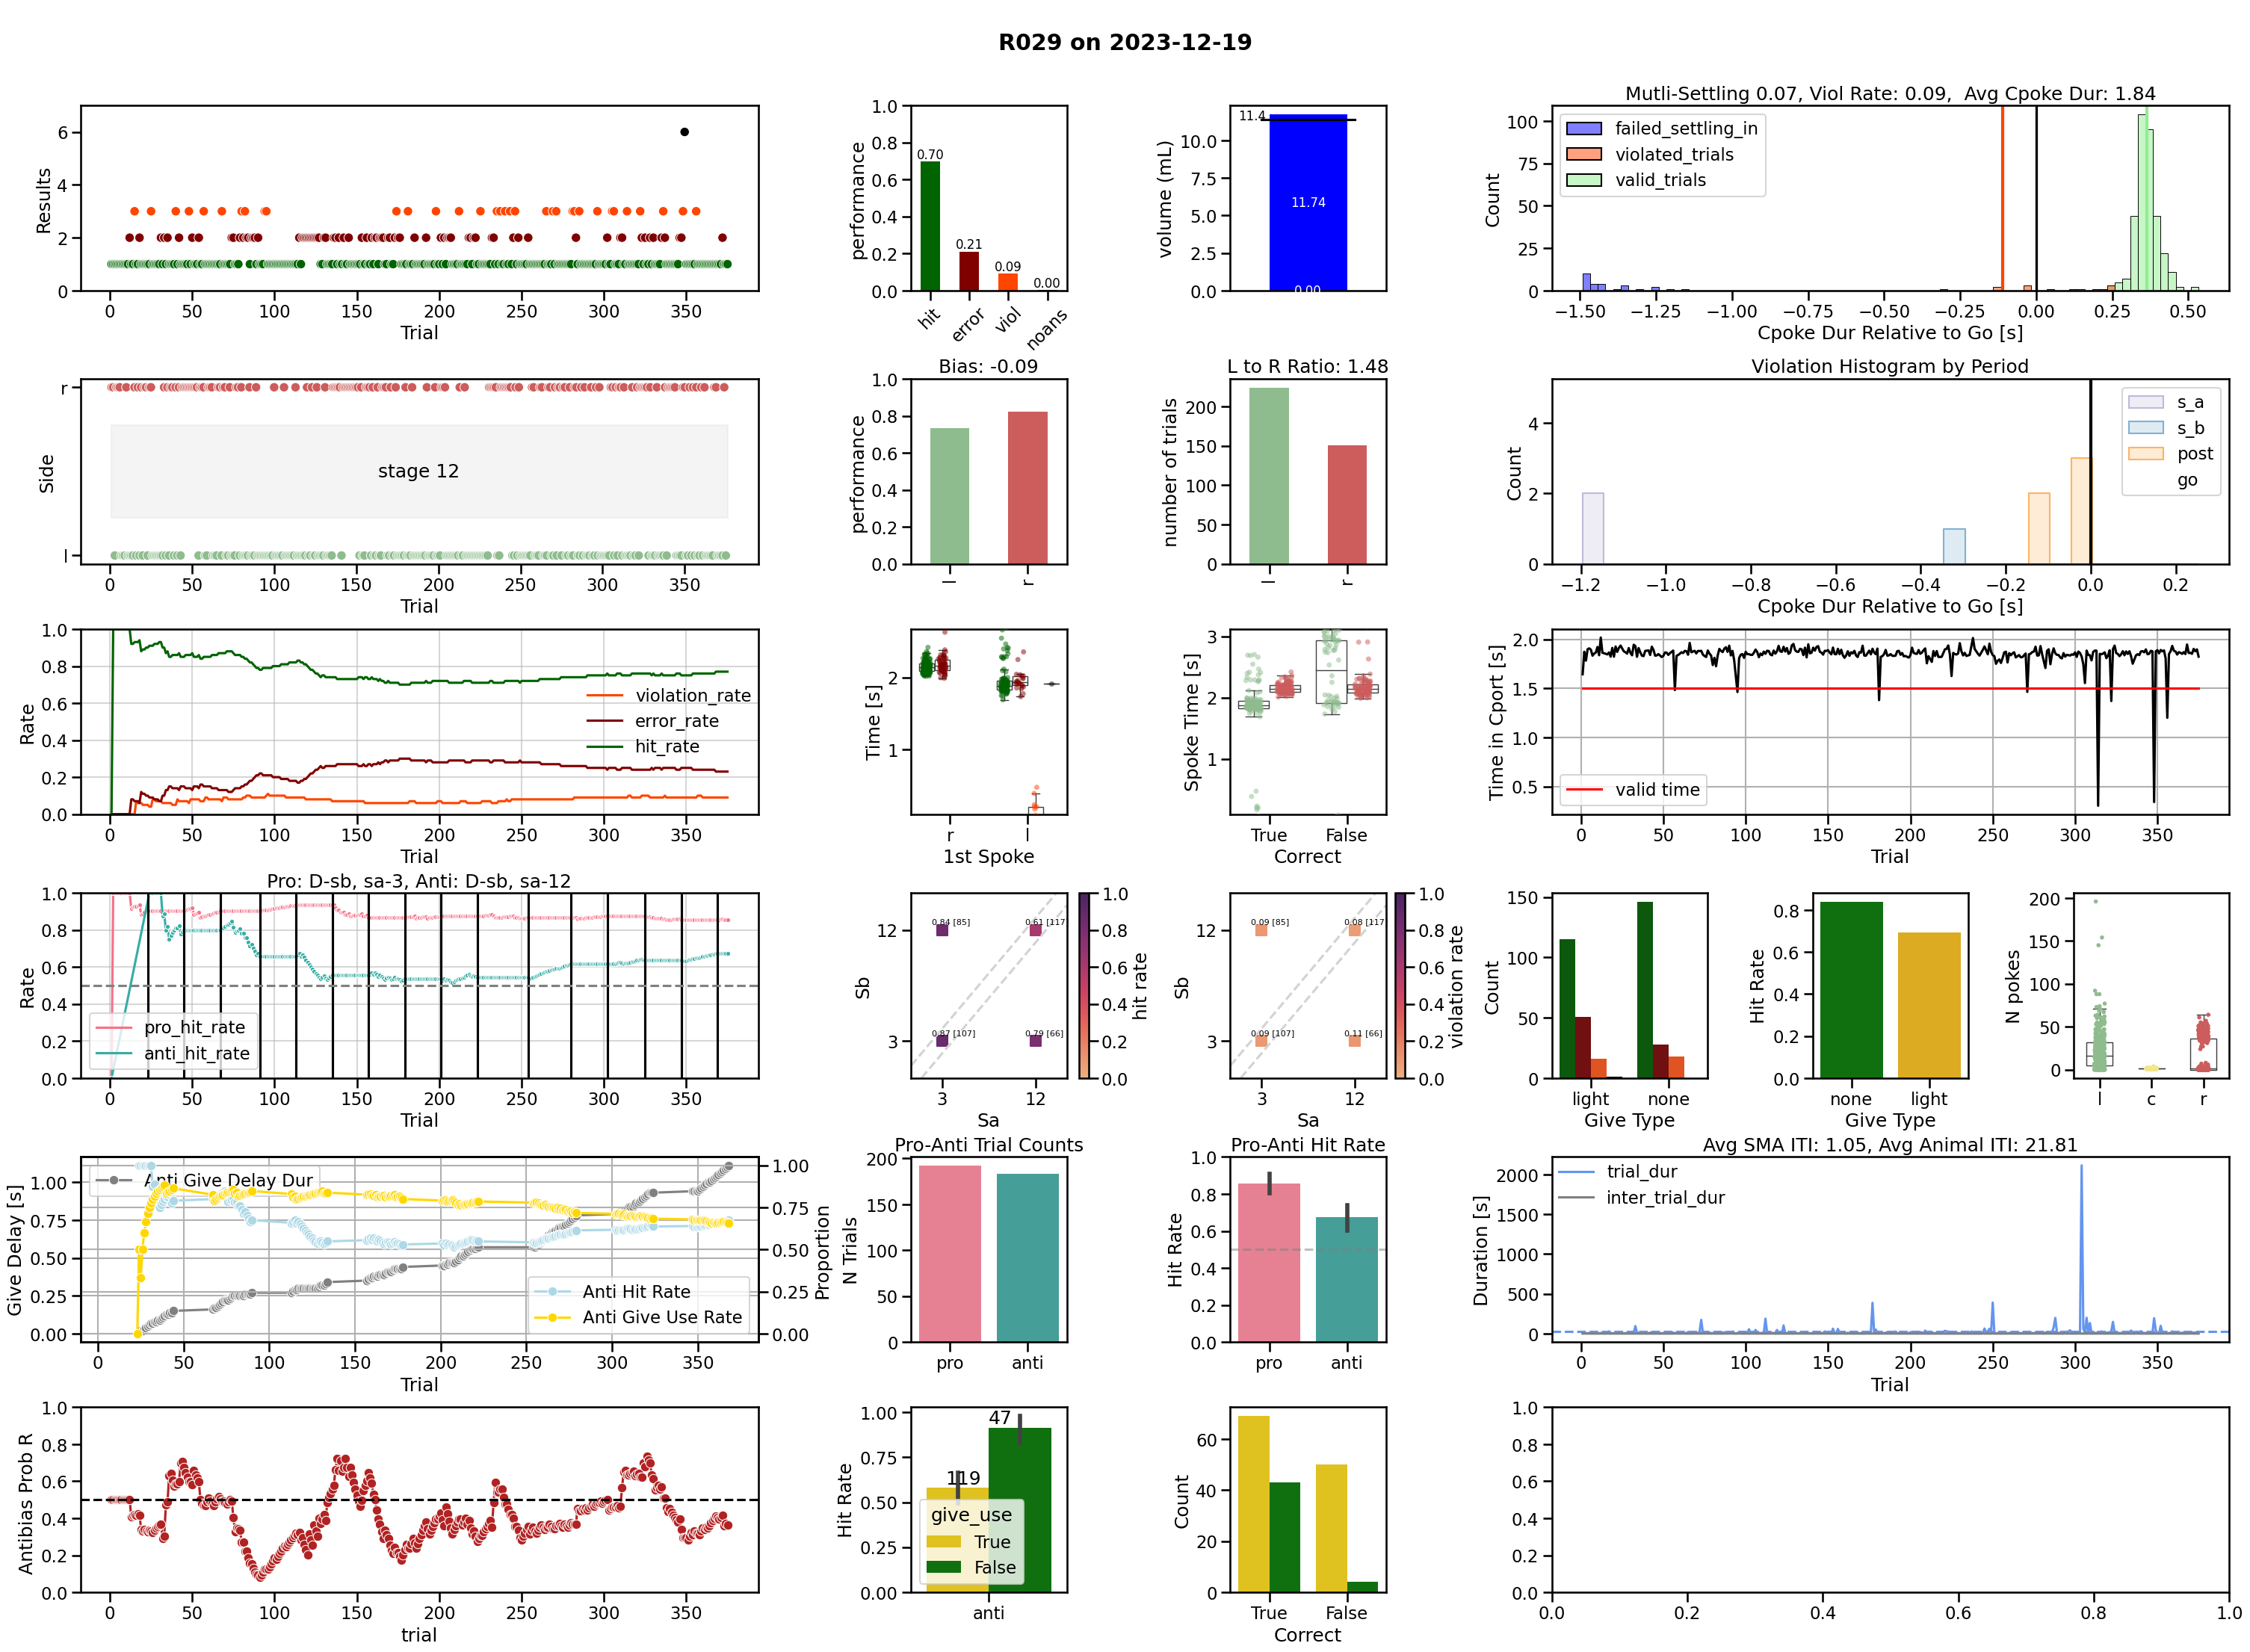

In [186]:
mutliplot_cpoke_pro_anti(tdf)

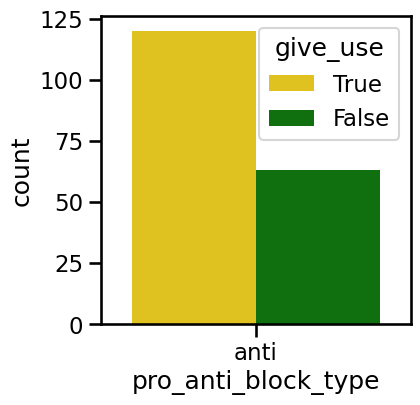

In [156]:
plot_anti_give_use_counts(tdf)

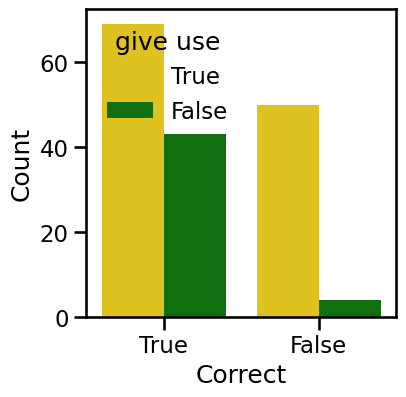

In [185]:
plot_anti_hit_counts_by_give_use(tdf)

## DAYS PLOTS

Next steps: pro anti specific row (or two?) of plots

- give del dur (min & max over days)
- give use rate over days (on anti)
    - might have to add into the load in trials_df
- hit rate by give use (on anti)
- pro/anti hit & viol thresholds + min block size(?)
- block switch type (static, sampled) + min block size (?)
- pro probability (stage 15 only)
- give type (?) might not actually need this if switching to light


In [198]:
# PATHS
if platform.system() == "Windows":
    FIGURES_PATH = Path(
        "C:\\Users\\JB\\github\\jbreda_animal_training\\figures\\mice\\cohort3"
    )
    DATA_PATH = Path("C:\\Users\\JB\\github\\jbreda_animal_training\\data\\days_dfs")
else:
    FIGURES_PATH = Path(
        "/Users/jessbreda/Desktop/github/jbreda_animal_training/figures/mice/cohort3"
    )
    DATA_PATH = Path(
        "/Users/jessbreda/Desktop/github/jbreda_animal_training/data/days_dfs"
    )

# ANIMALS
ANIMAL_IDS = ["R013", "R014", "R015"]

animal = ["R029"]

# DATES
# date_min, date_max = dju.return_date_window(latest_date=None, n_days_back=20)
date_min, date_max = dju.return_date_window(latest_date=None, n_days_back=2)
# few_days_ago = (datetime.today() - timedelta(days=4)).strftime("%Y-%m-%d")
today = datetime.today().date()

# LOAD IN TRIALS DATA
# trials_df = create_trials_df_from_dj(
#     animal_ids=ANIMAL_IDS, date_min="2023-11-21", date_max="2023-11-12"
# )
dtdf = create_trials_df_from_dj(animal_ids=animal, date_min=date_min, date_max=date_max)

fetched 3 sessions for R029 between 2023-12-18 and 2023-12-20


In [199]:
dtdf.columns

Index(['trial', 'animal_id', 'date', 'sess_id', 'result', 'hits', 'violations',
       'temperror', 'hit_rate', 'error_rate', 'violation_rate',
       'temp_error_rate', 'n_lpokes', 'n_cpokes', 'n_rpokes', 'trial_dur',
       'trial_start', 'valid_early_spoke', 'first_spoke', 'first_lpoke',
       'first_rpoke', 'n_settling_ins', 'avg_settling_in', 'cpoke_dur',
       'stage', 'curriculum', 'sides', 'SMA_set', 'is_match', 'sa', 'sb',
       'stimuli_on', 'settling_in_dur', 'legal_cbreak_dur', 'pre_dur',
       'adj_pre_dur', 'stimulus_dur', 'delay_dur', 'post_dur', 'sb_extra_dur',
       'viol_off_dur', 'pre_go_dur', 'inter_trial_dur', 'go_type', 'go_dur',
       'give_type_set', 'give_type_imp', 'give_frac', 'give_delay_dur',
       'give_xtra_light_delay_dur', 'give_use', 'replay_on', 'timeouts',
       'water_delivered', 'give_water_not_drunk', 'crash_hist', 'pro_stim_set',
       'anti_stim_set', 'pro_anti_block_type', 'block_switch_type',
       'pro_hit_rate', 'anti_hit_rate', 's

In [238]:
# days_trials_df = pd.read_csv(
#     "/Users/jessbreda/Desktop/github/jbreda_animal_training/data/offline/pro_anti_plots.csv"
# )

# days_trials_df.block_switch_type = days_trials_df.block_switch_type.replace(
#     {"['s']": "static"}
# )


# # "C:\\Users\\JB\\github\\jbreda_animal_training\\data\\offline\\pro_anti_plots.csv")

## Plot to make
[x] plot_block_size_days include std to determine the set block size parameter

-  might be worth splitting the multi plot into multiple functions because adding three plots to bottom mixes up the dates quite a bit

[x] plot_block_switch_type very similar to the give plot where its just a dot for the options over days don't care about color

[x] plot_block_switch_thresholds
    - if less than 15, plot viol & hit thresh rates, otherwise skip this plot and do pro probs instead

[x] plot pro probs
    - if at stage 15 plot pro probs over days

[x] add max block to n_blocks if in stage 15

[X] pro anti block switch type + days

[ ] anti give use rate

[ ] give/del metrics (maybe min & max?)

[ ]hit rate by give use (maybe, maybe not)

In [285]:
# trials_df = days_trials_df.query("animal_id == 'R013'").copy()

r29dd = (
    lazy_load_days_summary_df(
        date_min=date_min,
        date_max=date_max,
        animal_ids=["R0" + str(i) for i in range(20, 30)],
        f_name="R02s_days_df.csv",
        save_dir=du.DATA_PATH,
    )
    .query("animal_id == 'R029'")
    .copy()
)

Loaded pre-saved df with entries between 2023-12-18 and 2023-12-20.


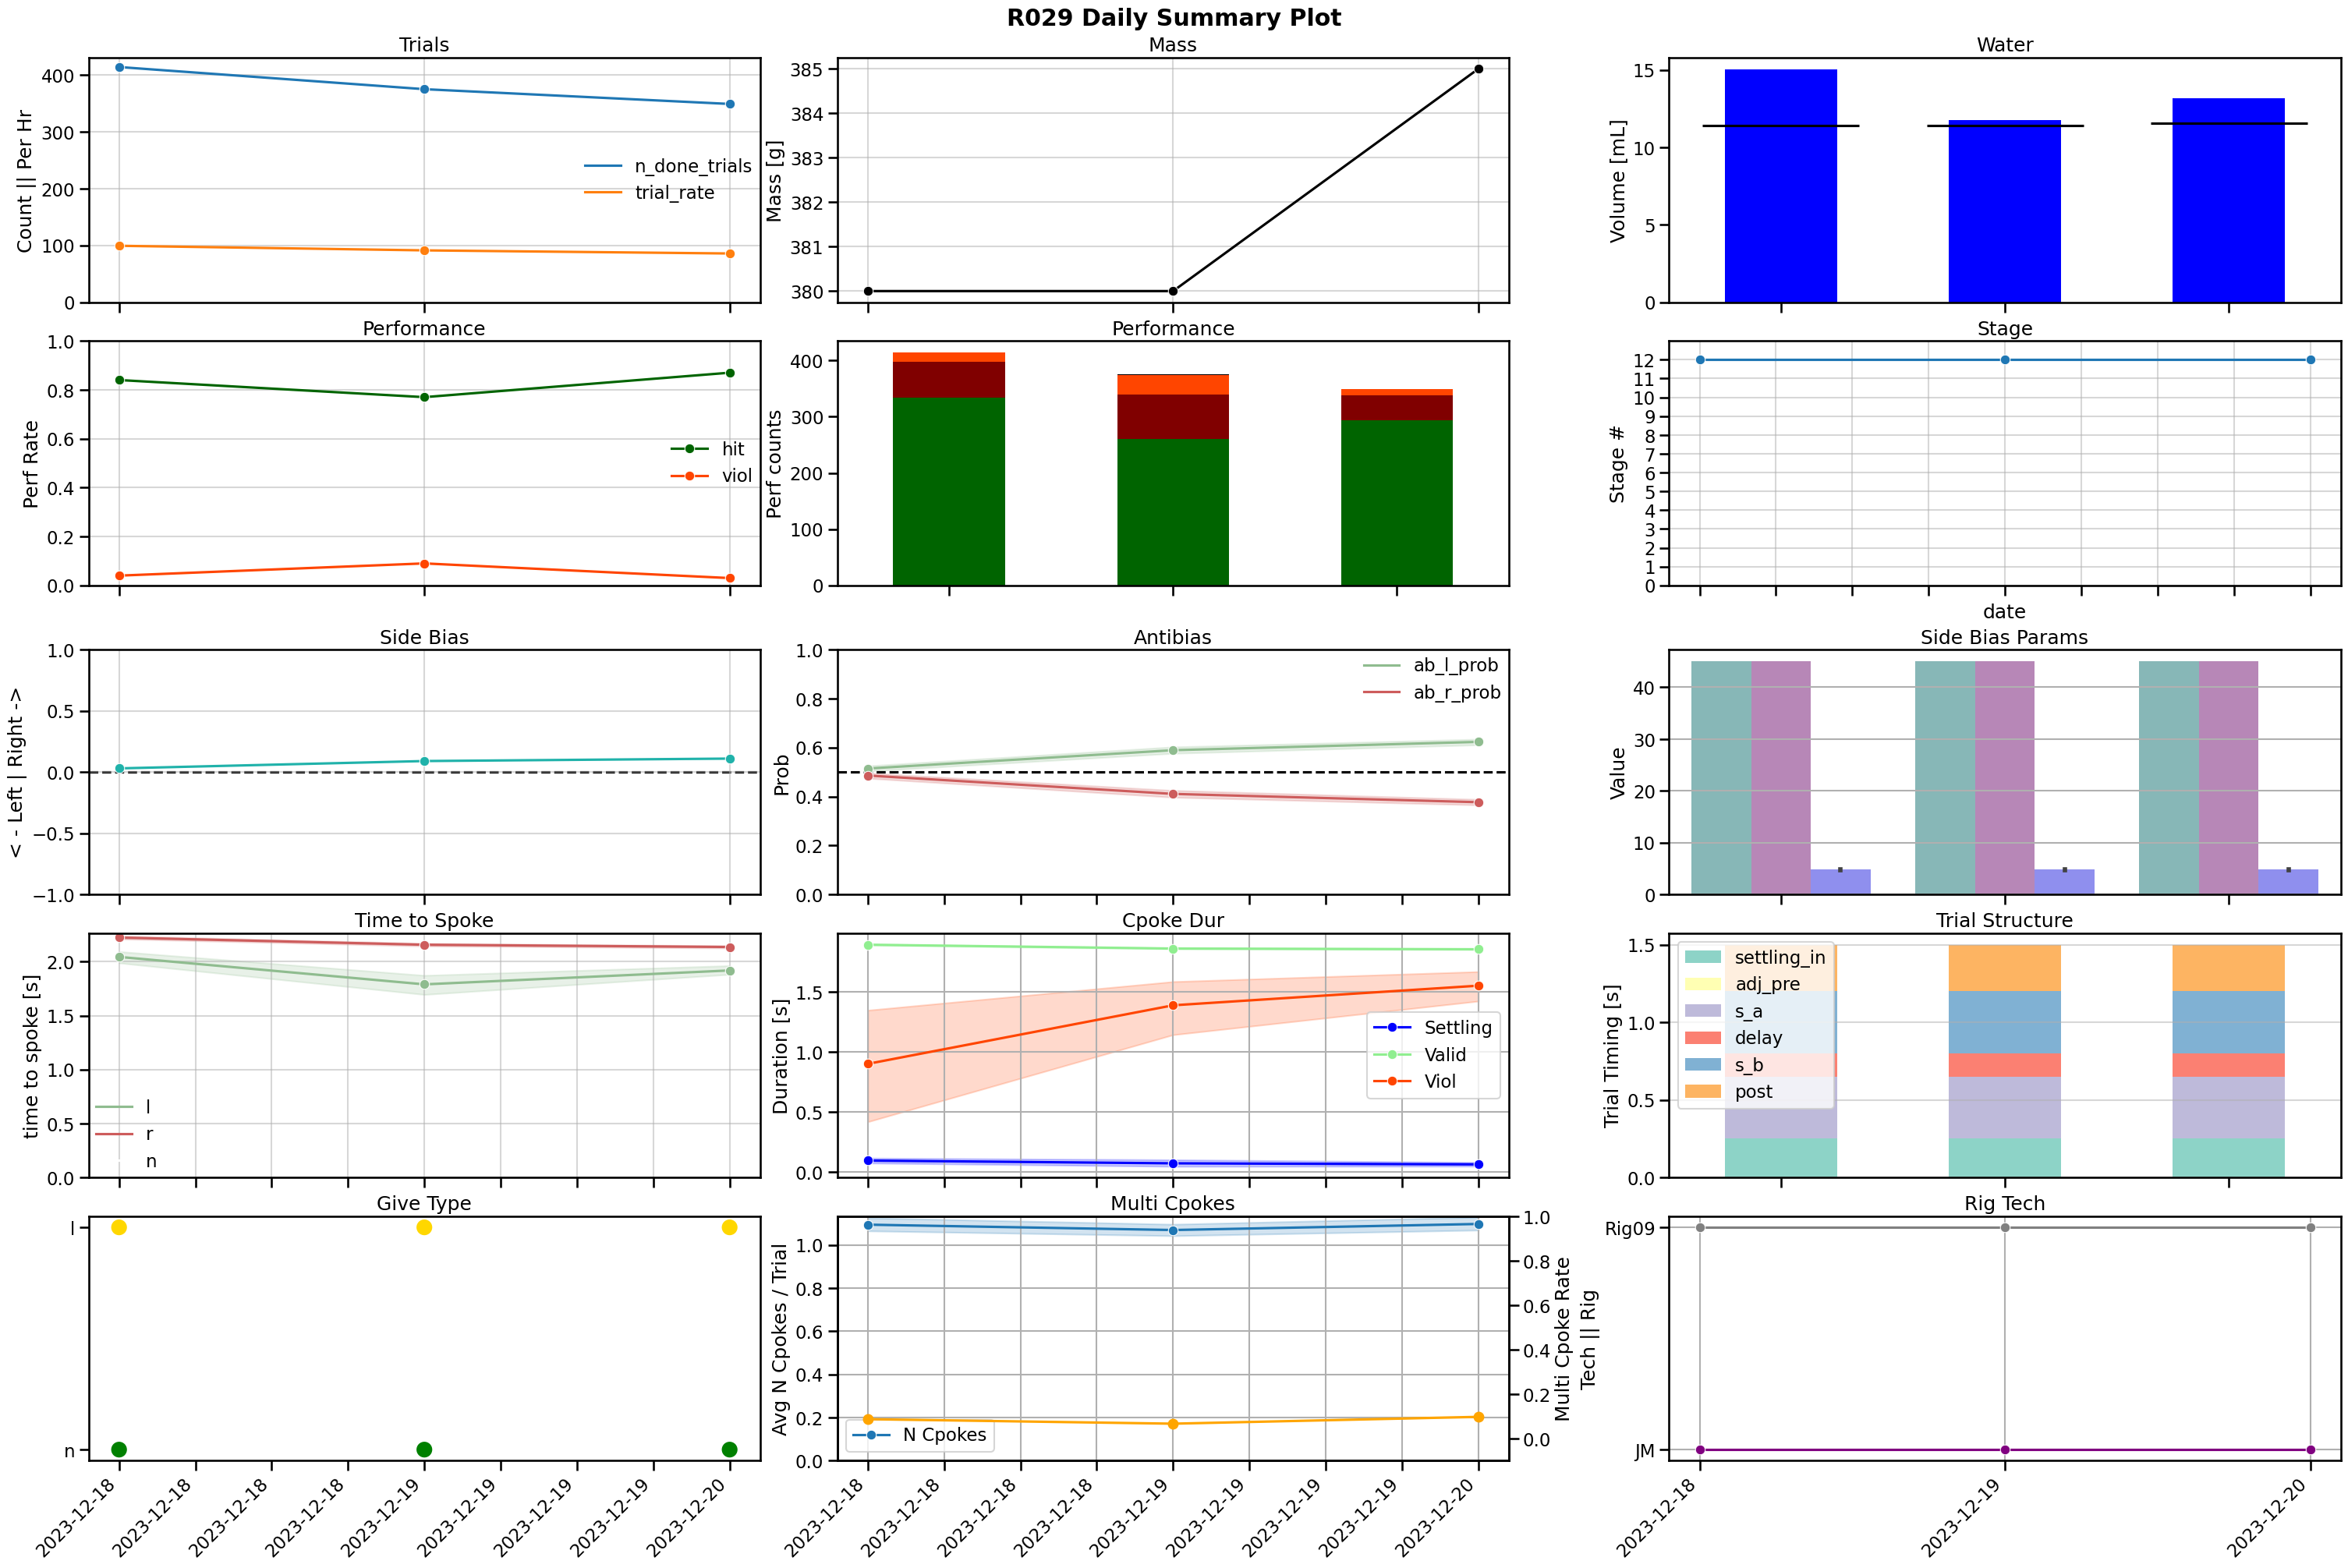

In [306]:
multi_day_summary_pre_pro_anti("R029", r29dd, dtdf)

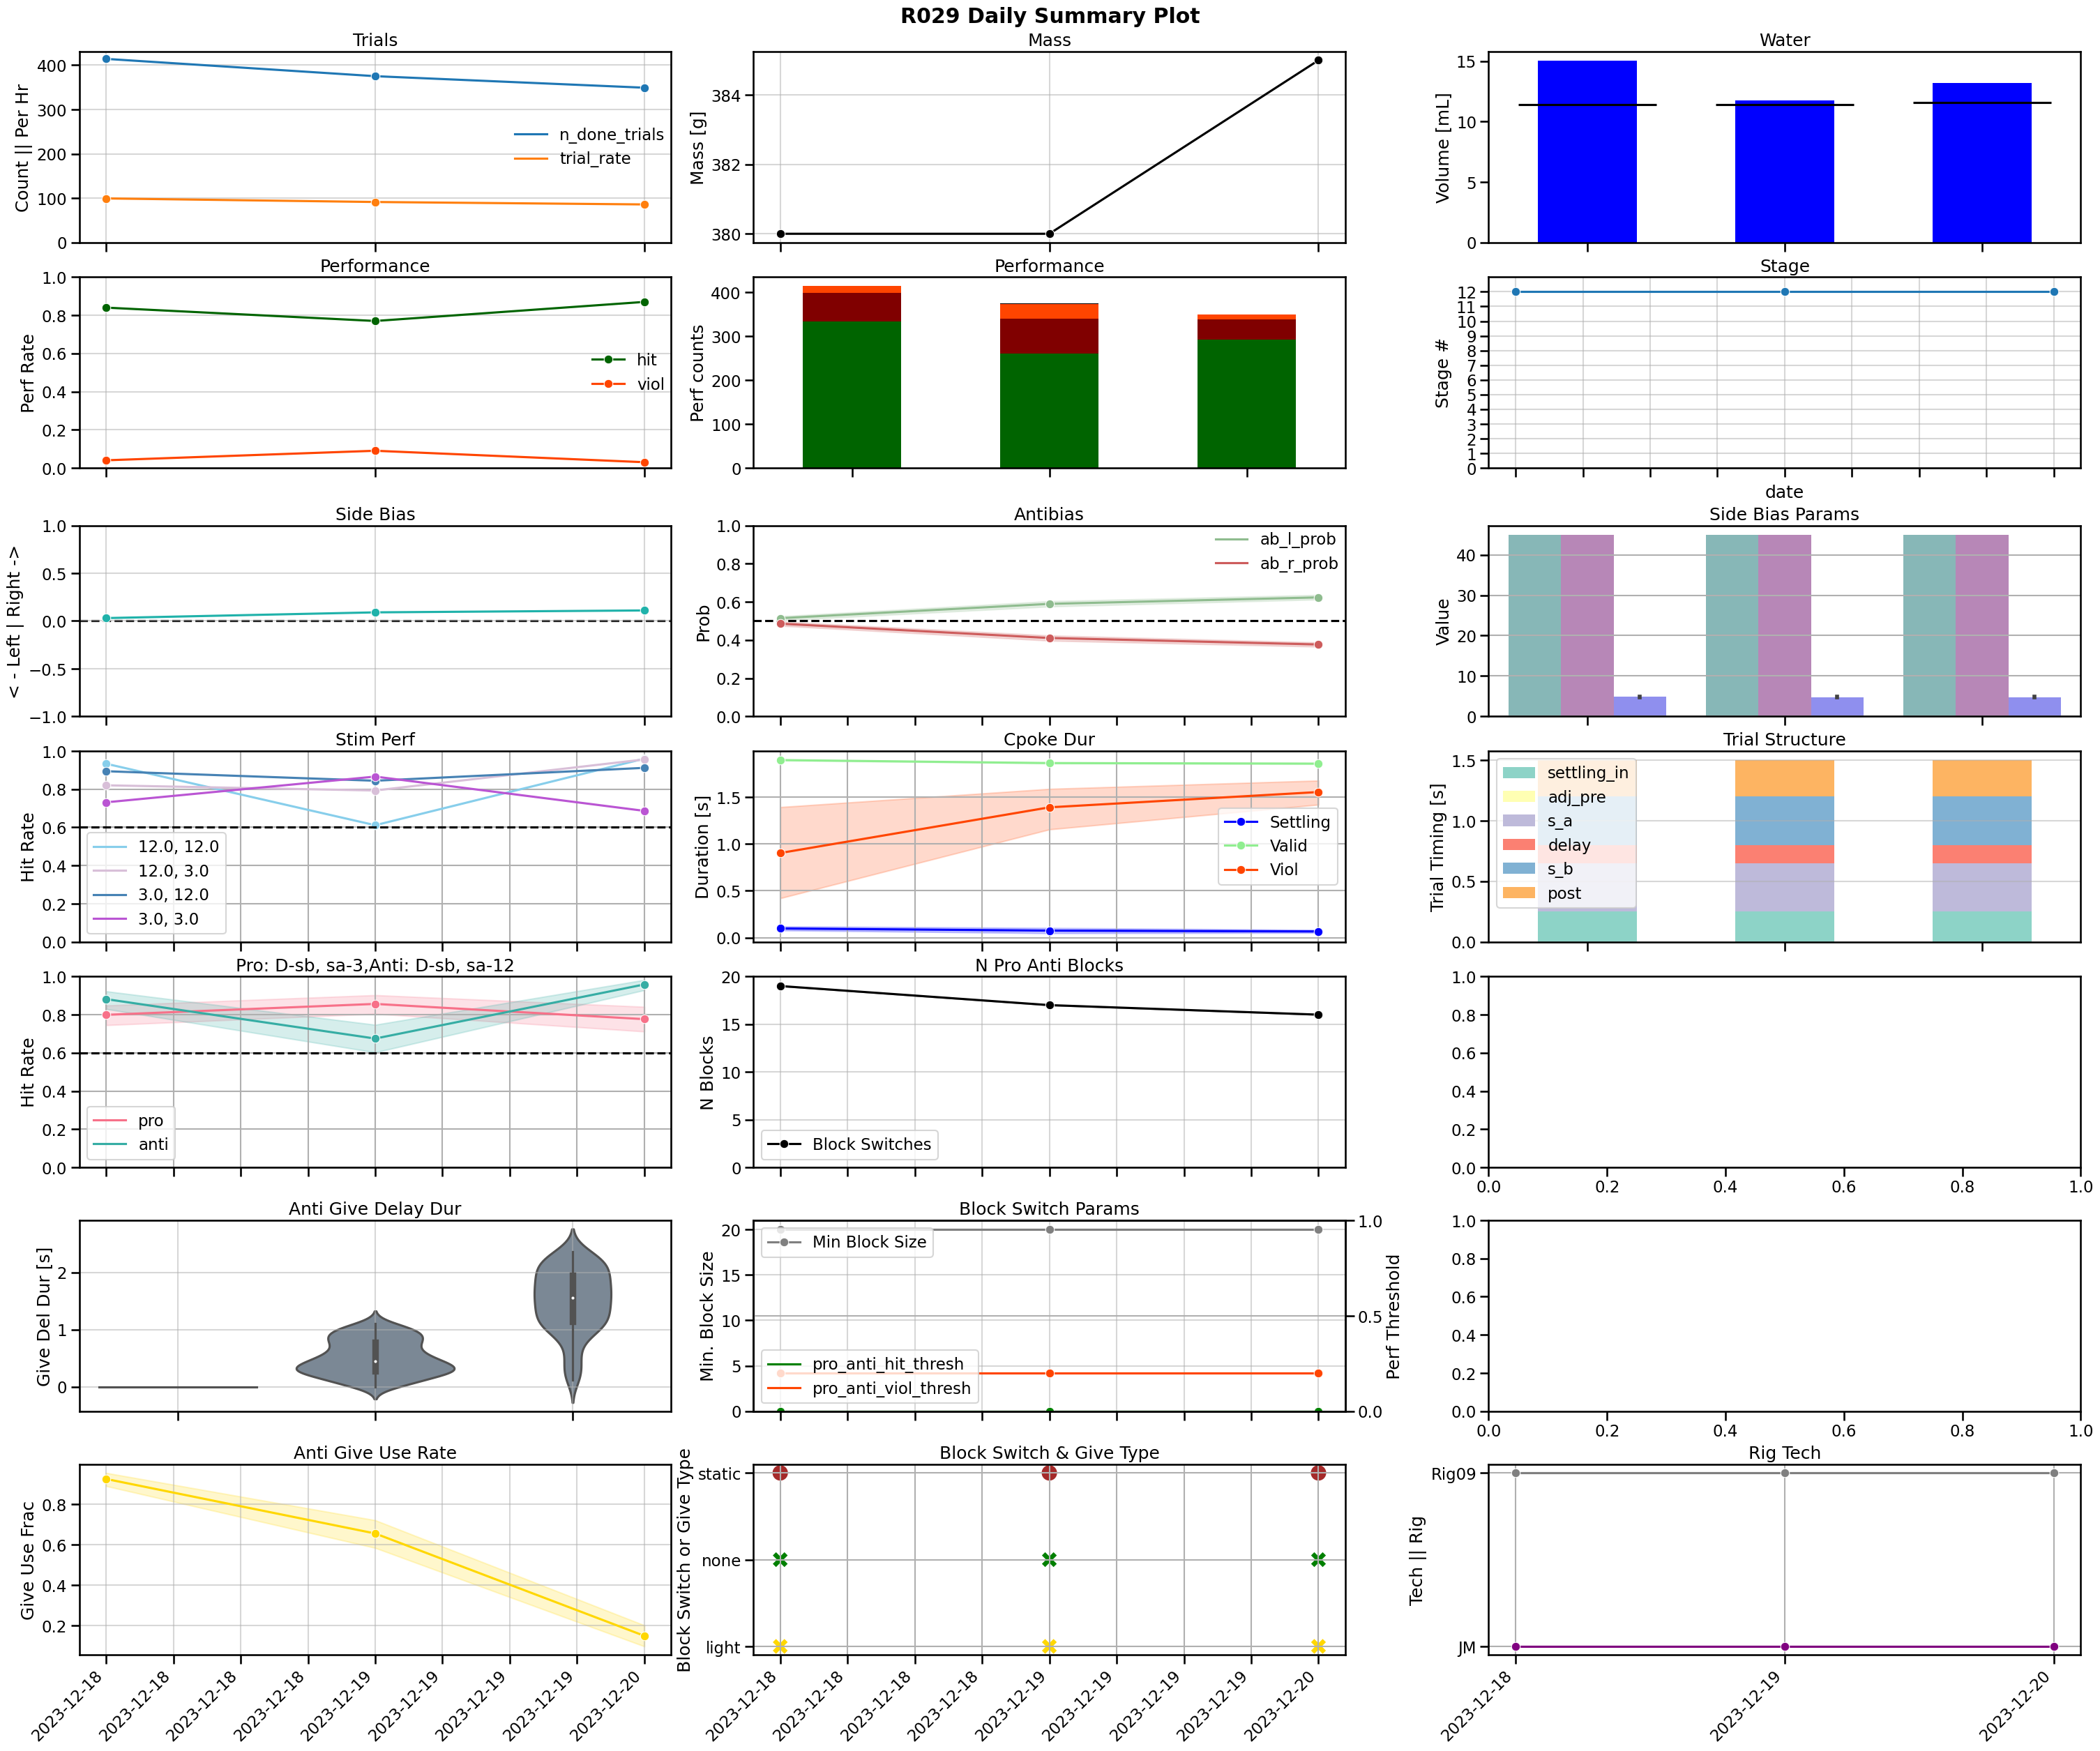

In [387]:
multiplot_multi_day_summary("R029", r29dd, dtdf)

In [338]:
dtdf.groupby("date").give_delay_dur.agg(["min", "mean", "max"])

min      mean    max
date                              
2023-12-18  0.001  0.001000  0.001
2023-12-19  0.001  0.491453  1.121
2023-12-20  0.121  1.443206  2.361

In [369]:
def plot_give_delay_dur_days(
    trials_df, ax=None, trial_subset="anti", title="", xaxis_label=False
):
    """
    Plot the distribution of pre-give delay durations
    across days.

    params
    ------

    trials_df: pd.DataFrame
        trials dataframe with columns `pro_anti_block_type`,
        `date`, and `give_delay_dur` with trials as row index
    ax : matplotlib.axes.Axes, de
        axes to plot on
    title : str, (default=None)
        title of plot
    xaxis_label : bool (optional, default = True)
        whether to include the xaxis label or not, this is useful when
        plotting multiple plots on the same figure
    """

    if ax is None:
        _, ax = pu.make_fig()

    if trial_subset:
        data = trials_df.query("pro_anti_block_type == @trial_subset").copy()
    else:
        data = trials_df.copy()

    sns.violinplot(
        data=data,
        x="date",
        y="give_delay_dur",
        ax=ax,
        color="lightslategray",
    )

    # aesthetics
    pu.set_date_x_ticks(ax, xaxis_label)
    ax.grid(alpha=0.5)
    _ = ax.set(title=title, xlabel="", ylabel="Give Del Dur [s]")

    return None

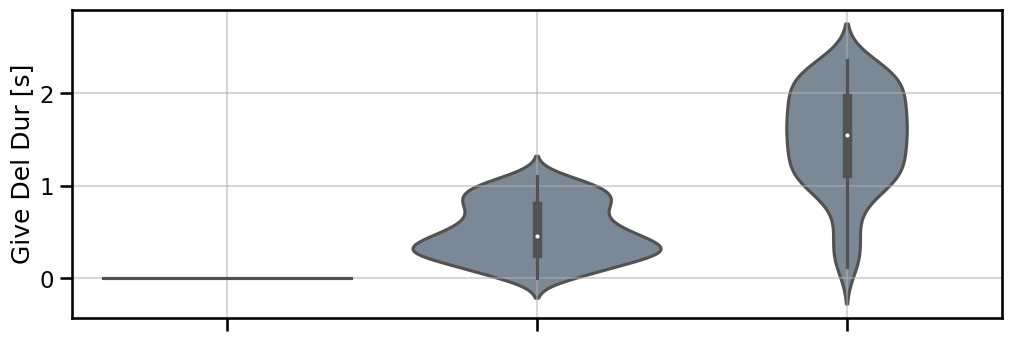

In [368]:
plot_give_delay_dur_days(dtdf)

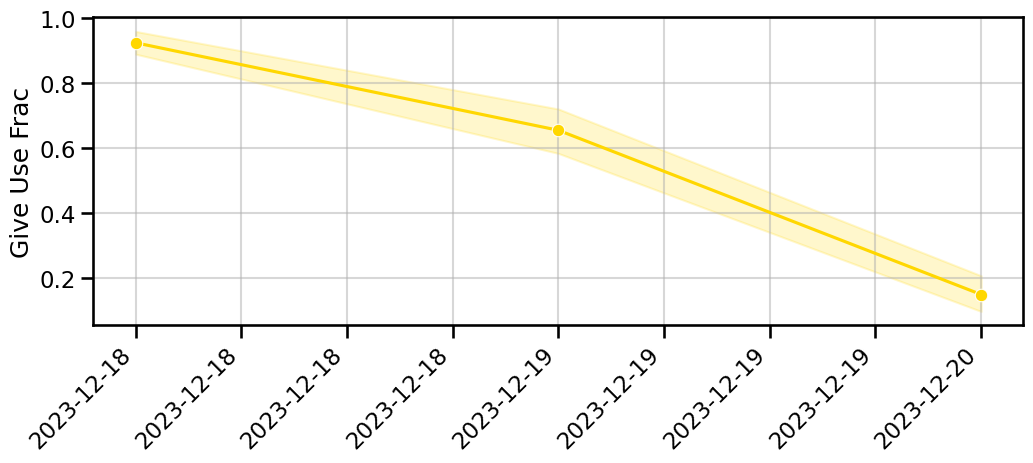

In [385]:
def plot_give_use_rate_days(
    trials_df, ax=None, trial_subset="anti", title="", xaxis_label=False
):
    if trial_subset:
        data = trials_df.query("pro_anti_block_type == @trial_subset").copy()
    else:
        data = trials_df.copy()

    if ax is None:
        _, ax = pu.make_fig()

    sns.lineplot(
        data=data,
        x="date",
        y="give_use",
        marker="o",
        color="gold",
        ax=ax,
    )

    # aesthetics
    pu.set_date_x_ticks(ax, xaxis_label)
    ax.grid(alpha=0.5)
    _ = ax.set(title=title, xlabel="", ylabel="Give Use Frac")

    return None


plot_give_use_rate_days(dtdf, xaxis_label=True)

In [192]:
def plot_pro_prob(trials_df, ax=None, title="", xaxis_label=False):
    """
    plot the probability of pro trials over days
    NOTE this is only for stages where blocks turn
    off and pro/anti trials are sampled from a
    normal distribution parameterized by pro rate

    params
    ------

    """
    if ax is None:
        _, ax = pu.make_fig()

    sns.lineplot(data=trials_df, x="date", y="pro_prob", color="pink", marker="o")

    # aethetics
    pu.set_date_x_ticks(ax, xaxis_label)
    ax.grid()
    ax.set(ylabel="Pro Probability", xlabel="", title=title, ylim=(0, 1))

    return None

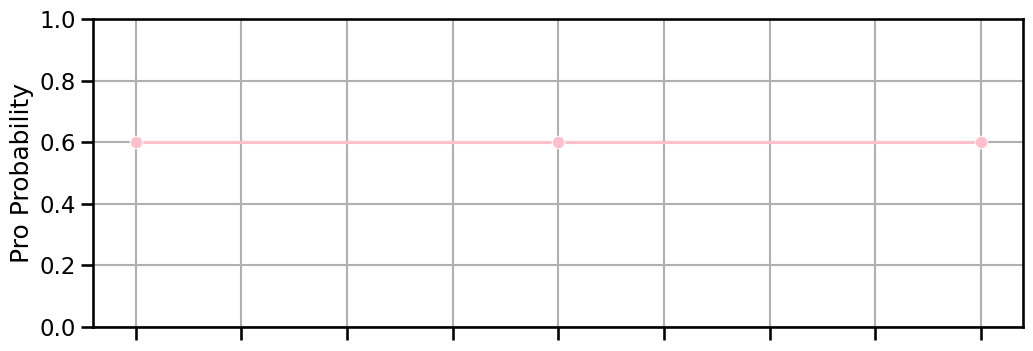

In [201]:
plot_pro_prob(dtdf)

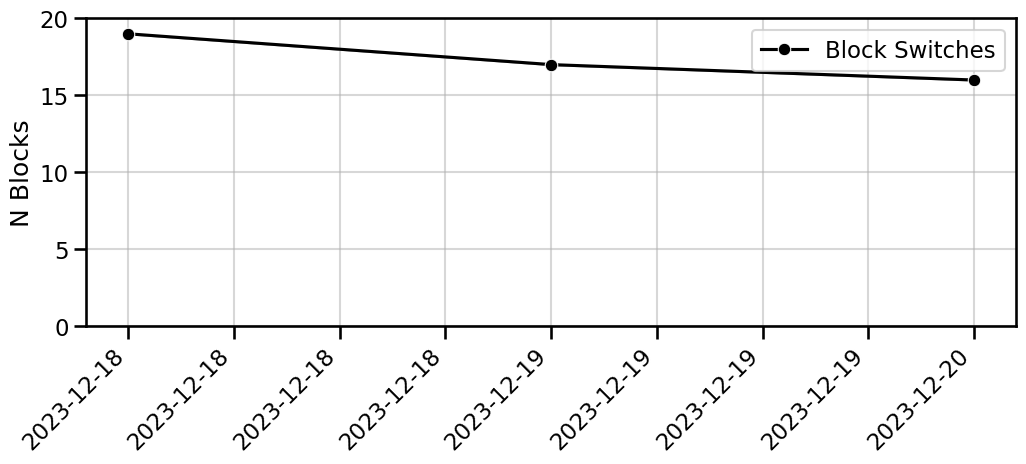

In [202]:
plot_n_pro_anti_blocks_days(dtdf)

In [270]:
trials_df.stage.unique()

array([14.])

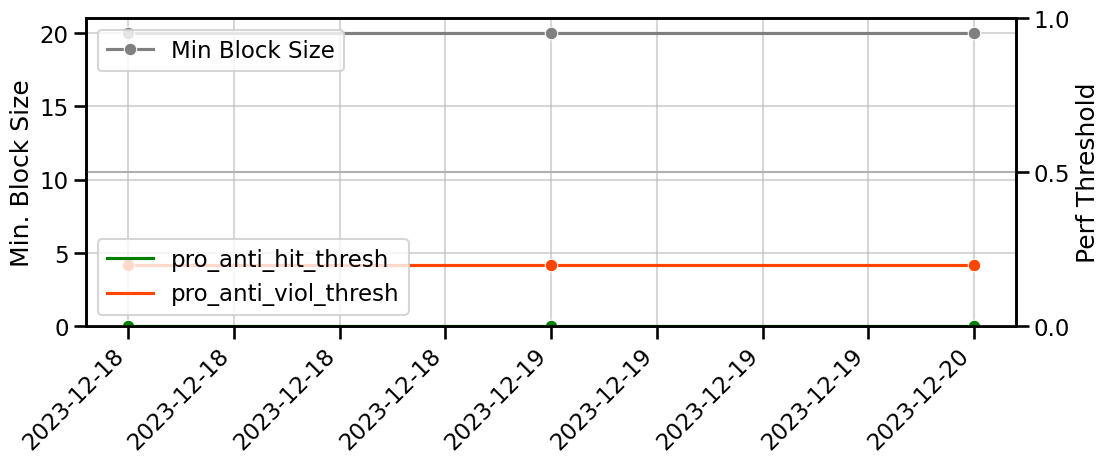

In [325]:
plot_block_switch_params(dtdf, xaxis_label=True)

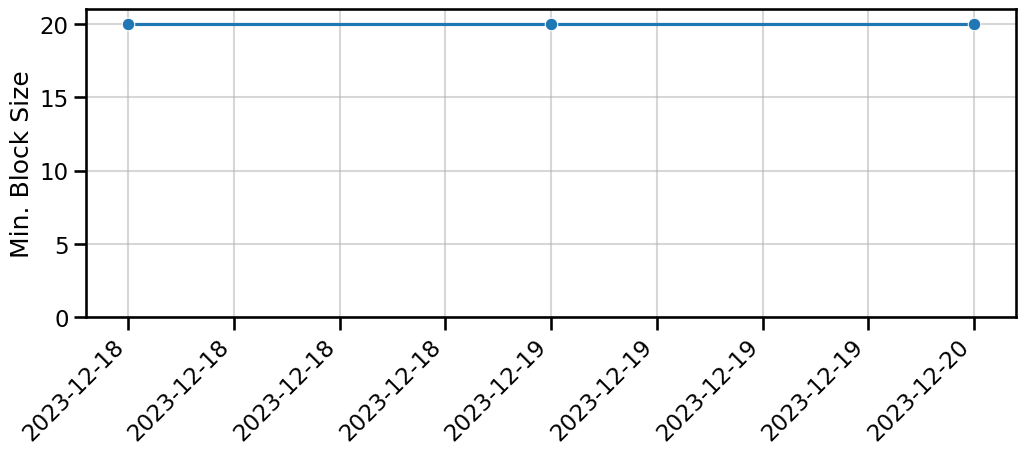

In [203]:
plot_min_block_size(dtdf)

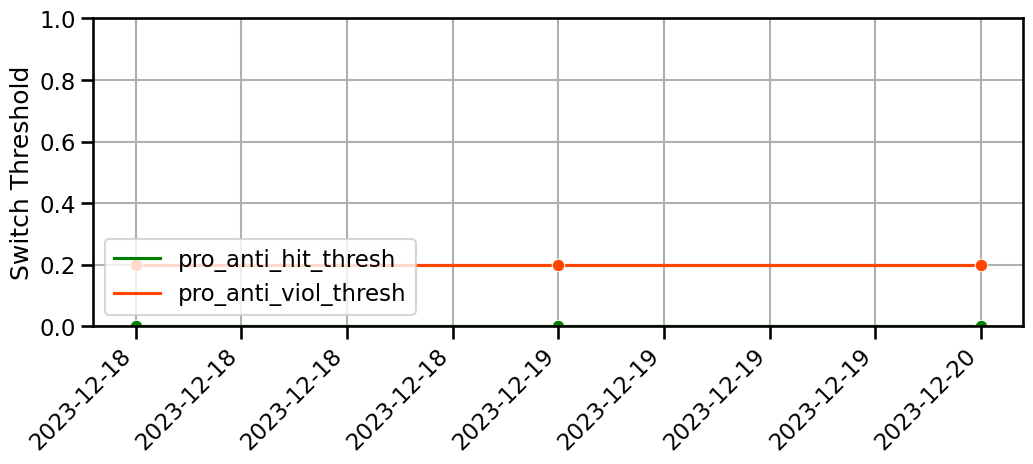

In [278]:
plot_block_switch_thresholds(dtdf)

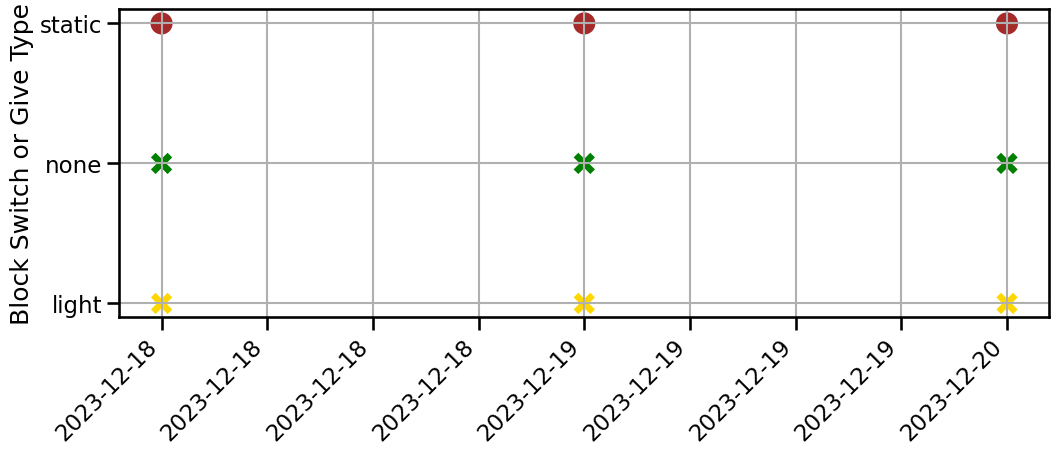

In [276]:
plot_give_type_and_block_switch_days(dtdf, legend=False)

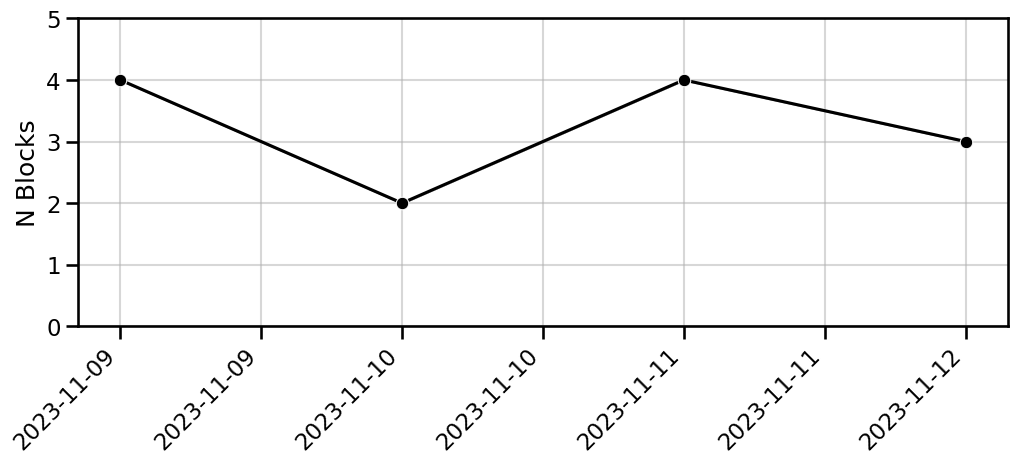

In [126]:
fig, ax = pu.make_fig()


plot_n_pro_anti_blocks_days(days_trials_df, ax)

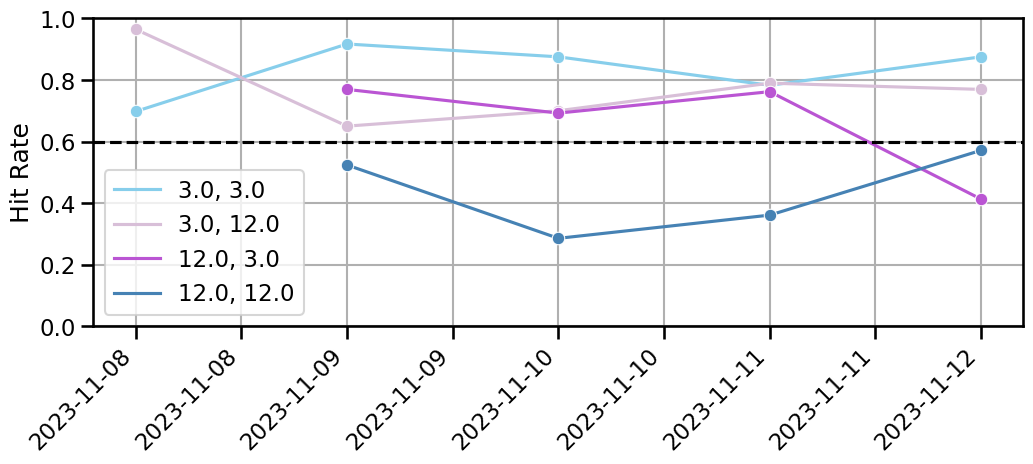

In [110]:
fig, ax = pu.make_fig()
plot_stim_performance(days_trials_df, ax)

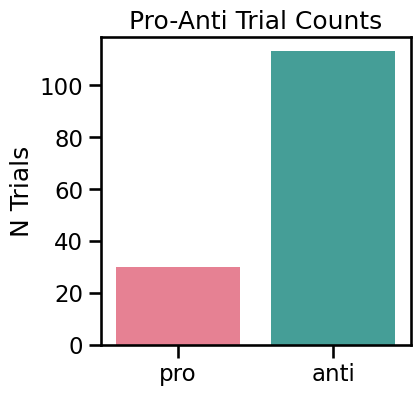

In [200]:



plot_pro_anti_count_summary(trials_df)

In [173]:
trials_df.dropna(inplace=True)

trials_df

Empty DataFrame
Columns: [trial, animal_id, date, sess_id, result, hits, violations, temperror, hit_rate, error_rate, violation_rate, temp_error_rate, n_lpokes, n_cpokes, n_rpokes, trial_dur, trial_start, valid_early_spoke, first_spoke, first_lpoke, first_rpoke, n_settling_ins, avg_settling_in, cpoke_dur, stage, curriculum, sides, SMA_set, is_match, sa, sb, stimuli_on, settling_in_dur, legal_cbreak_dur, pre_dur, adj_pre_dur, stimulus_dur, delay_dur, post_dur, sb_extra_dur, viol_off_dur, pre_go_dur, inter_trial_dur, go_type, go_dur, give_type_set, give_type_imp, give_frac, give_delay_dur, give_xtra_light_delay_dur, give_use, replay_on, timeouts, water_delivered, give_water_not_drunk, crash_hist, pro_stim_set, anti_stim_set, pro_anti_block_type, pro_hit_rate, anti_hit_rate, stim_set, was_block_swtich, n_blocks, pro_anti_on, volume_multiplier, l_water_vol, r_water_vol, ab_l_prob, ab_r_prob, ab_beta, ab_tau, exp_del_tau, exp_del_min, exp_del_max, sound_pair, min_time_to_spoke]
Index: []

[0 rows x 77 columns]

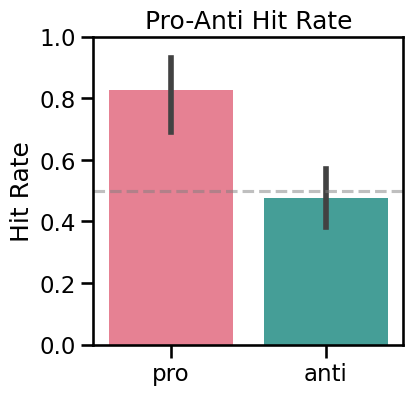

In [196]:
fig, ax = pu.make_fig("s")





plot_hit_rate_by_pro_anti(trials_df, ax)

TypeError: boolean value of NA is ambiguous

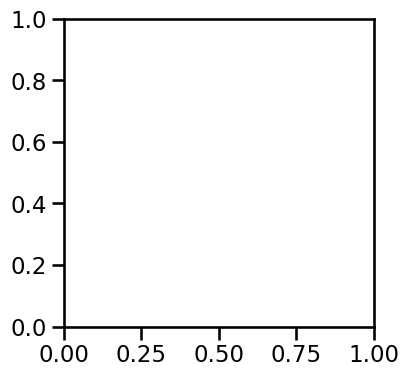

In [159]:
fig, ax = pu.make_fig("s")
hit_rate_by_pro_anti = (
    trials_df.groupby("pro_anti_block_type").hits.mean().reset_index()
)
sns.barplot(
    data=trials_df,
    x="pro_anti_block_type",
    y="hits",
    ax=ax,
    # hue="pro_anti_block_type",
    # dodge=False,
    # palette="husl",
    # hue_order=["pro", "anti"],
)

ax.axhline(0.5, ls="--", color="gray", alpha=0.5)
_ = ax.set(
    xlabel="",
    ylabel="Hit Rate",
    title="Pro-Anti Trial Counts",
    ylim=(0, 1),
)

ax.legend().remove()

In [153]:
def plot_pro_anti_count_summary(trials_df, ax, title=""):
    """
    plot the count of pro/anti types implemented and color by
    what was actually set in the GUI

    params
    ------
    trials_df : pandas.DataFrame
        trials dataframe with columns `give_type_imp` and `give_type_set`
        with trials as row index
    ax : matplotlib.axes
        axis to plot to
    """

    return None

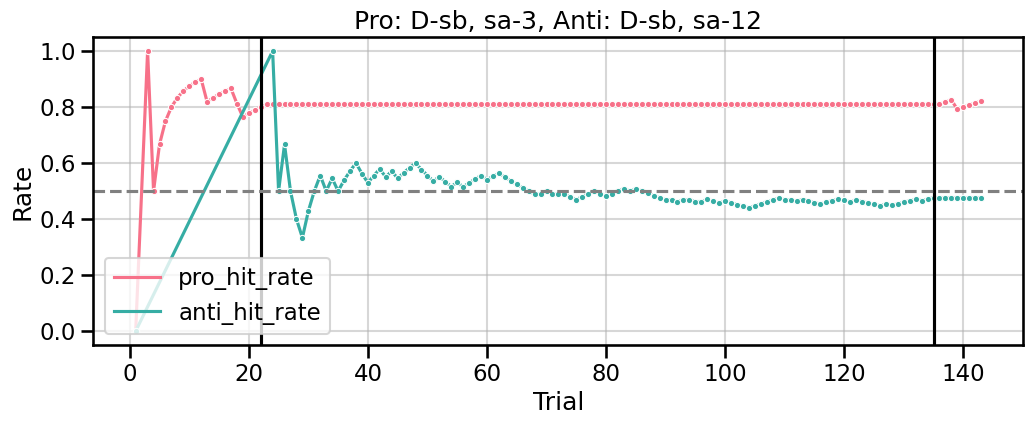

In [86]:
fig, ax = pu.make_fig()
plot_pro_anti_perf_rates(trials_df, ax=ax)

In [19]:
multi_day_trials_df = create_trials_df_from_dj(
    animal_ids=ANIMAL_IDS, date_min="2023-08-01"
)

fetched 23 sessions for R015 between 2023-08-01 and 2023-08-31


In [46]:
def mutliplot_cpoke_decrease_give(trials_df, save_out=False, save_path=None):
    """
    generate summary plot for cpoke stages sounds are just being turned on
    the key thing to visualize here is the duration of the sound stimuli
    relative to the delay & the violation rate wrt periods

    params
    ------
    trials_df : DataFrame
        trials dataframe generated by create_trials_df() for a single
        animal on a single date with trials as row index
    save_out : bool (default=False)
        whether to save out the figure
    save_path : str (default=None)
        path to save the figure to
    """
    layout = """
        AAABCDDD
        EEEFGHHH
        IIIJKLLL
        MMMNOPQR
        SSSTUVVV
    """
    fig = plt.figure(constrained_layout=True, figsize=(30, 20))

    plt.suptitle(
        f"\n{trials_df.animal_id.iloc[0]} on {trials_df.date.iloc[0]}\n",
        fontweight="semibold",
    )
    ax_dict = fig.subplot_mosaic(layout)  # ax to plot to
    # pu.identify_axes(ax_dict)  # prints the letter for id

    ## ROW 1
    plot_results(trials_df, ax=ax_dict["A"])
    plot_result_summary(trials_df, ax=ax_dict["B"])
    plot_watering_amounts(trials_df, ax=ax_dict["C"])
    plot_cpoke_distributions(trials_df, ax=ax_dict["D"], mode="violations")

    ## ROW 2
    plot_correct_side(trials_df, ax=ax_dict["E"])
    plot_stage_info(trials_df, ax=ax_dict["E"])
    plot_side_bias_summary(trials_df, ax=ax_dict["F"])
    plot_side_count_summary(trials_df, ax=ax_dict["G"])
    plot_violations_by_period(trials_df, ax=ax_dict["H"])

    ## ROW 3
    plot_performance_rates(trials_df, ax=ax_dict["I"])
    plot_first_spoke_summary_by_loc_and_result(trials_df, ax=ax_dict["J"])
    plot_first_spokes_summary_by_correct_side_and_loc(trials_df, ax=ax_dict["K"])
    plot_cpokes_over_trials(trials_df, ax=ax_dict["L"], mode="violations")

    ## ROW 4
    plot_give_info(trials_df, ax=ax_dict["M"])
    plot_stim_grid_performance(trials_df, ax=ax_dict["N"], mode="hits")
    plot_stim_grid_performance(trials_df, ax=ax_dict["O"], mode="violations")
    plot_result_by_give(trials_df, ax=ax_dict["P"])
    plot_hit_rate_by_give(trials_df, ax=ax_dict["Q"])
    plot_npokes_summary(trials_df, ax=ax_dict["R"])

    ## ROW 5
    plot_antibias_r_probs(trials_df, ax=ax_dict["S"])
    plot_stim_grid_performance(
        trials_df.query("give_type_imp == 'none'"),
        ax=ax_dict["T"],
        mode="hits",
        title="Give perf",
    )
    plot_stim_grid_performance(
        trials_df.query("give_type_imp == 'none'"),
        ax=ax_dict["U"],
        mode="violations",
        title="Give perf",
    )
    plot_trial_dur(trials_df, ax=ax_dict["V"])

    if save_out:
        plt.savefig(save_path, bbox_inches="tight")
        plt.close("all")
    else:
        plt.show()

    return None

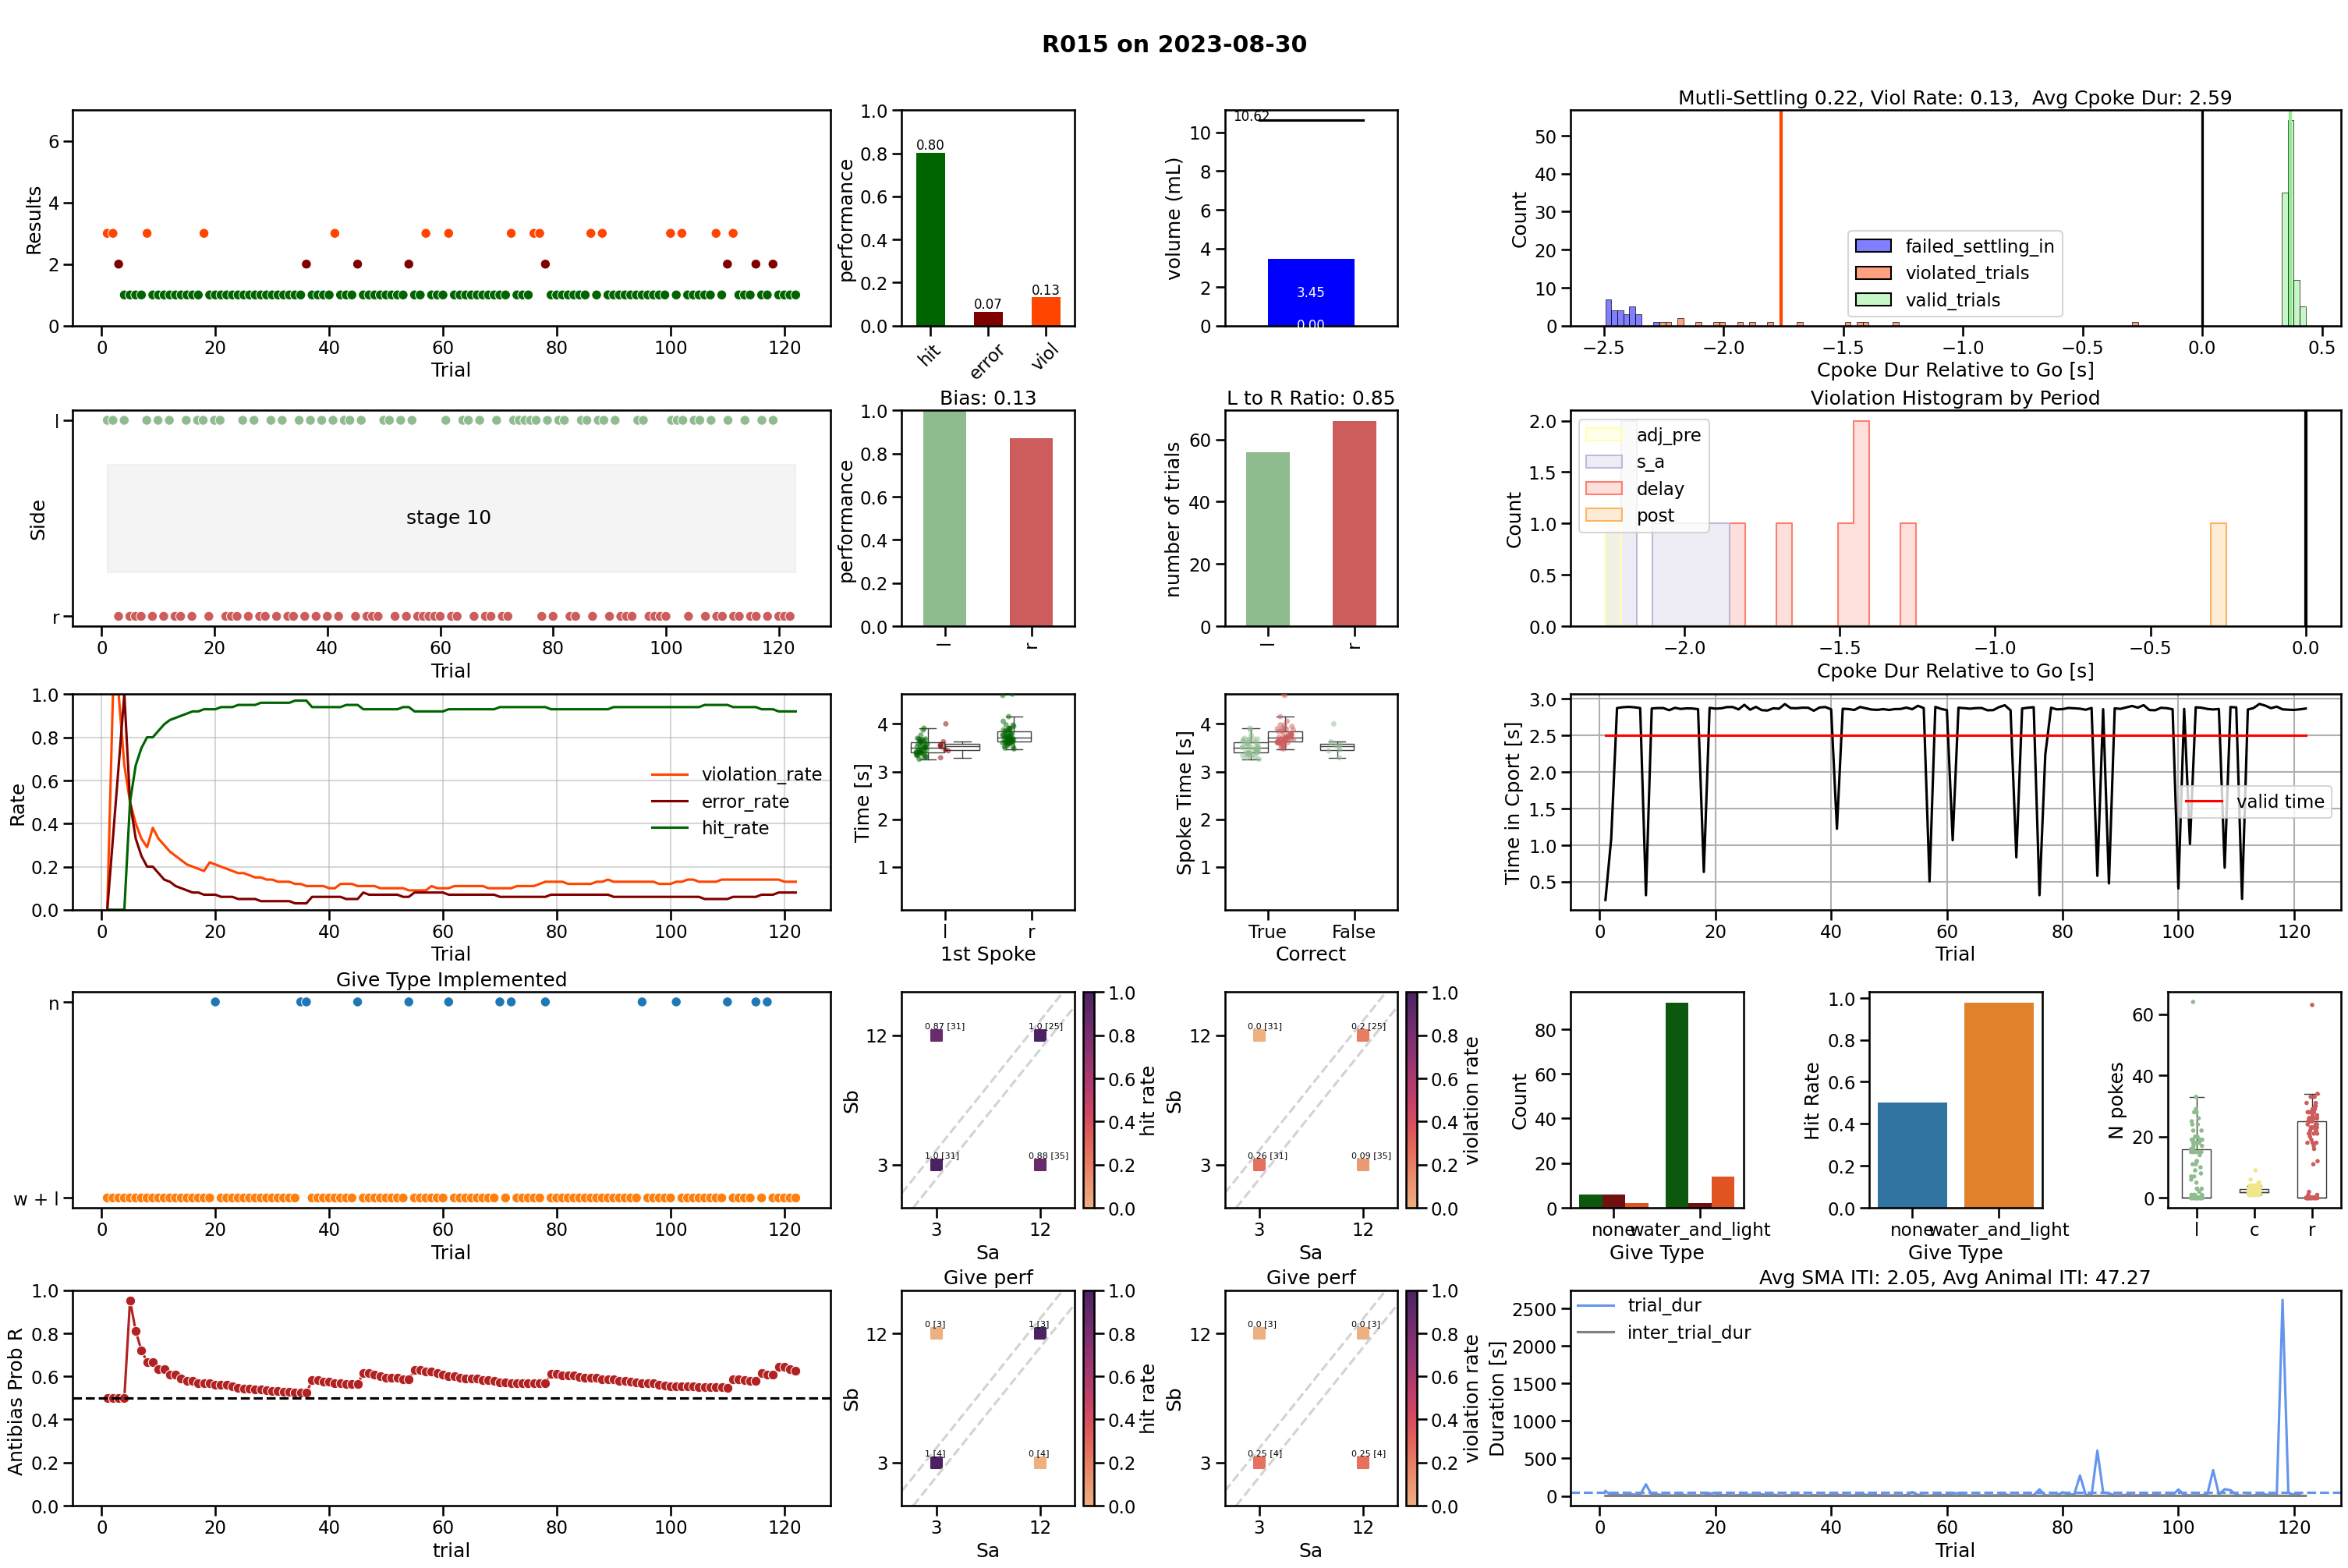

In [47]:
mutliplot_cpoke_decrease_give(trials_df)

final notes:
* will want to test tomorrow if this plot actual works in logic
* will also want to add antibias plot to other earlier stages

In [7]:
FPATH = "/Users/jessbreda/Desktop/github/jbreda_animal_training/data/offline/cpoke_dur_debug"
trials_df = pd.read_csv(FPATH + "/r015.csv")
TRIALS = pd.read_csv(FPATH + "/all_cpokes.csv")

In [3]:
# f_name = "R01s_days_df.csv"

# # days_df.to_csv(DATA_PATH / f_name, index=False)


# days_df = lazy_load_days_summary_df(
#     date_min=date_min,
#     date_max="2023-08-02",
#     animal_ids=ANIMAL_IDS,
#     save_dir=DATA_PATH,
#     f_name=f_name,
#     save_out=False,
# )

making R014_2023-08-13_day_summary


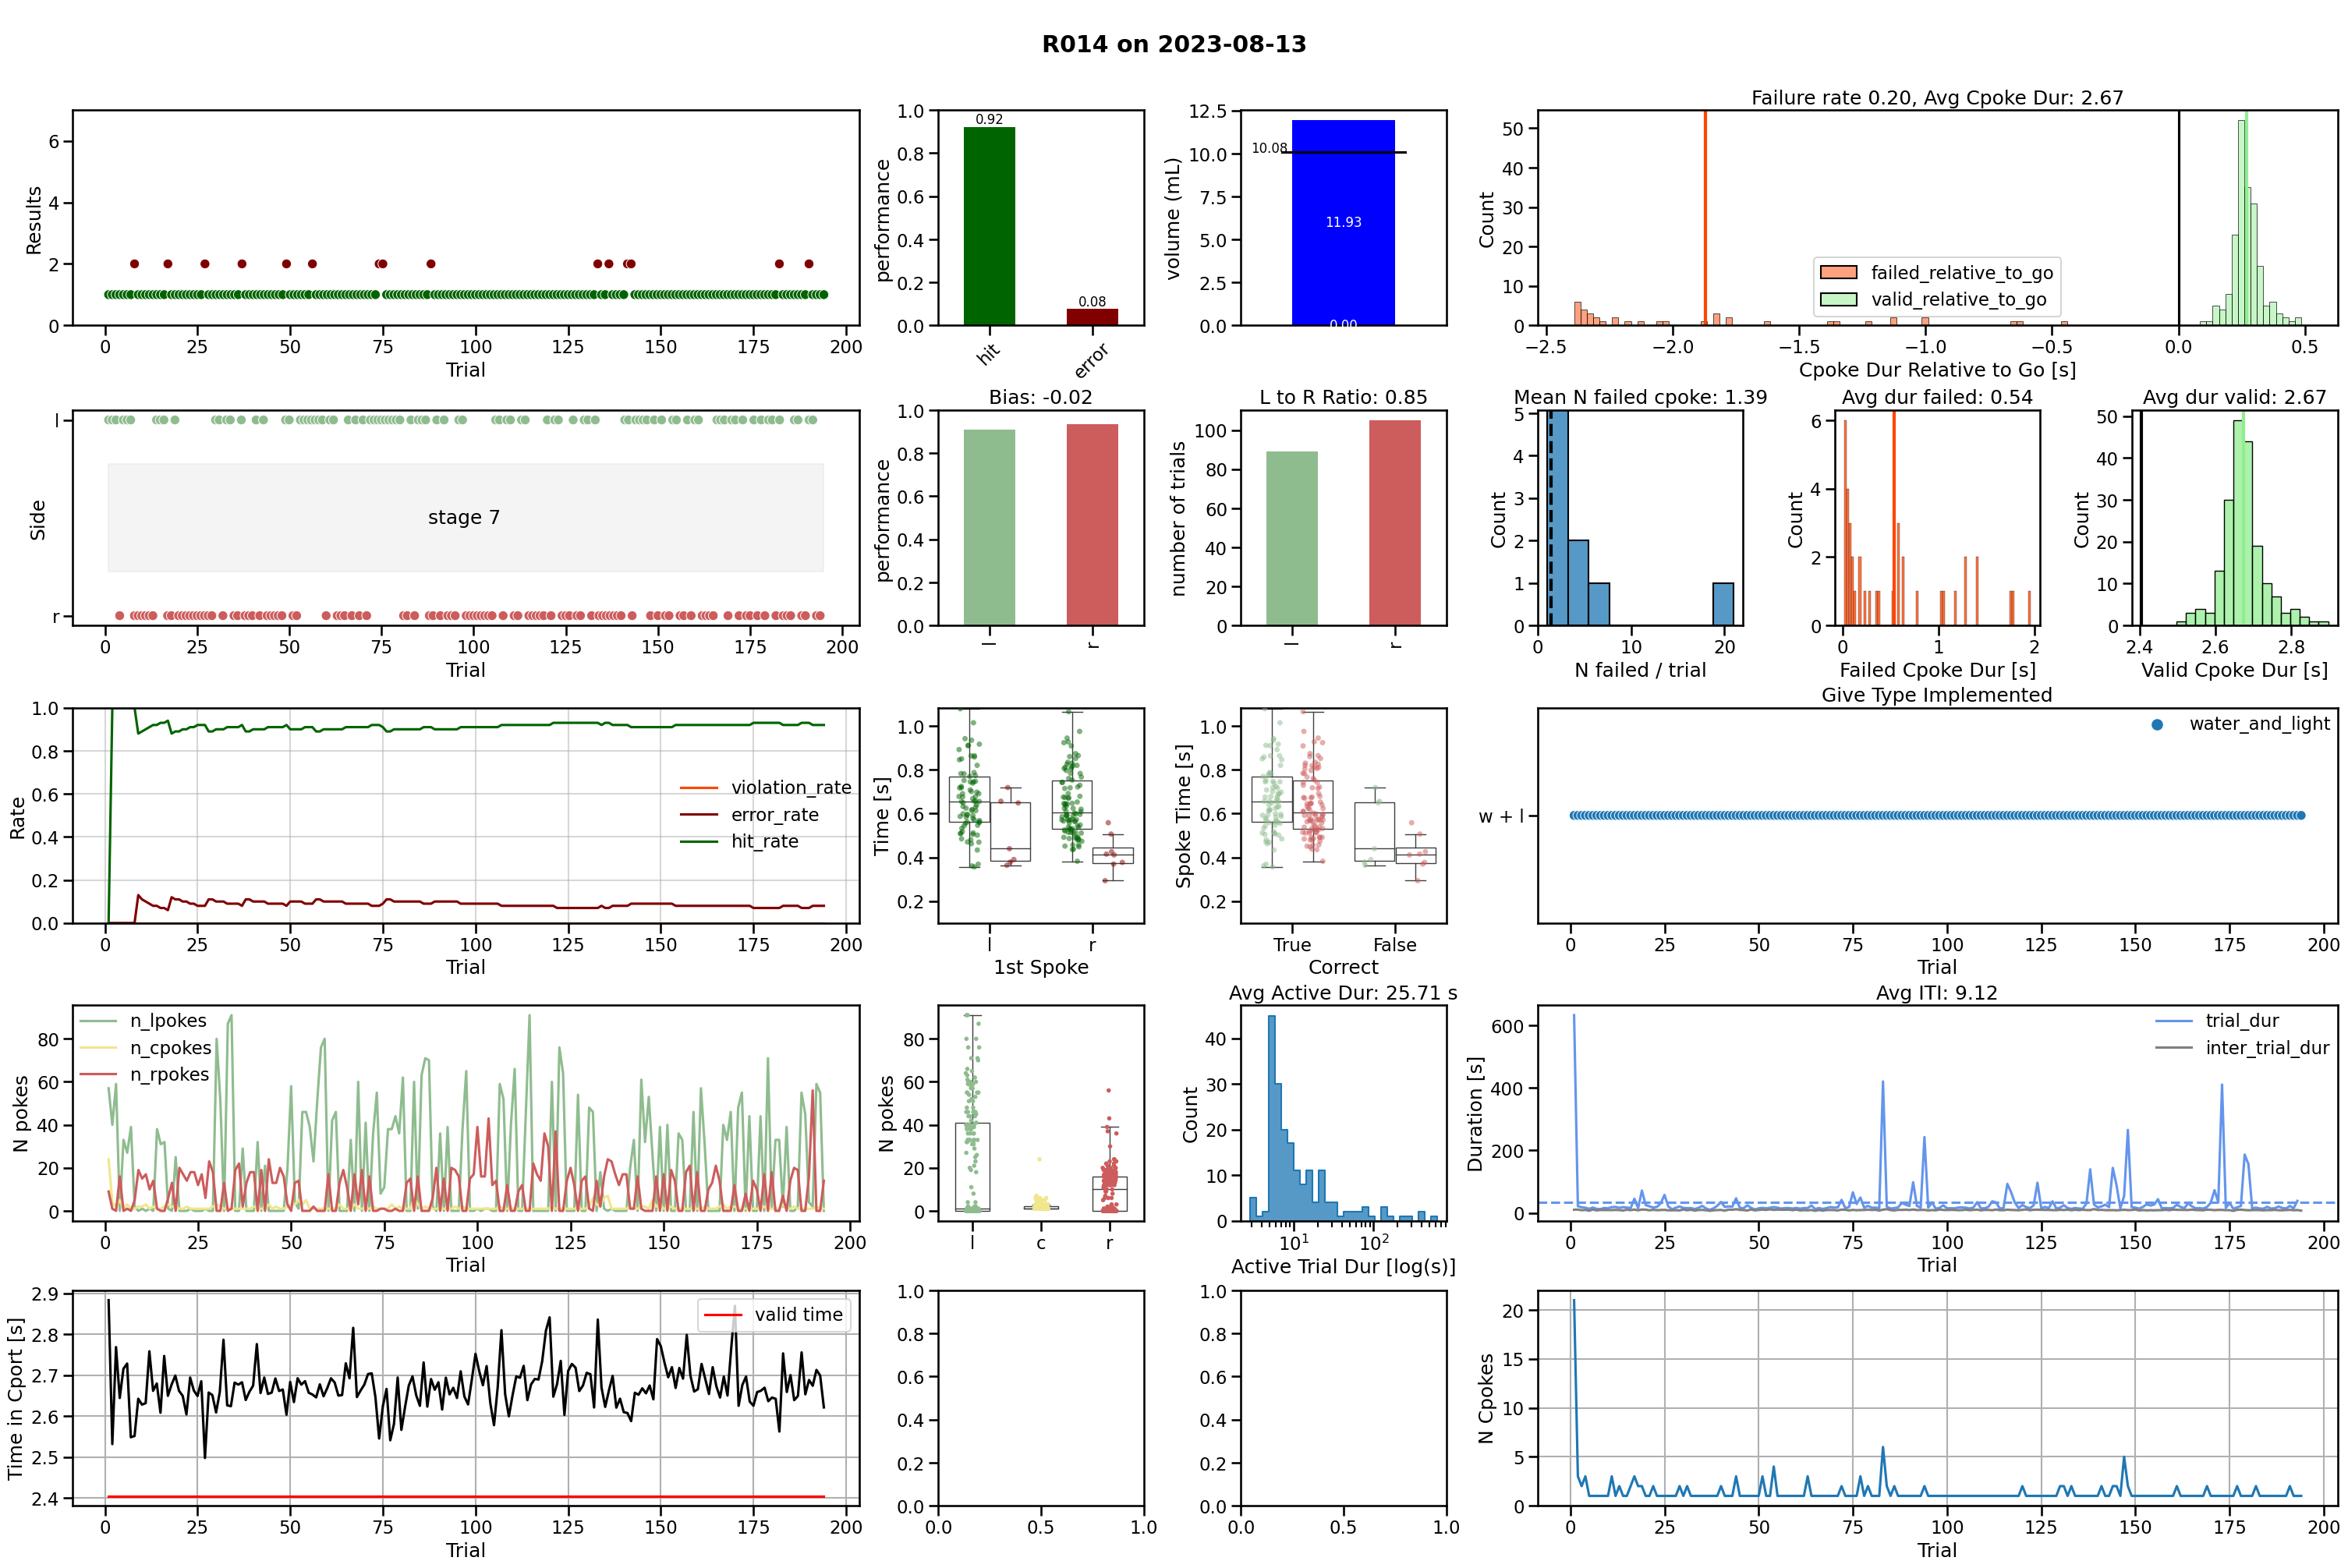

In [18]:
import os

fig_path = Path(
    "/Users/jessbreda/Desktop/github/jbreda_animal_training/code/training_performance"
)
multiplot_single_day_summaries(trials_df, fig_path, save_out=False, overwrite=False)

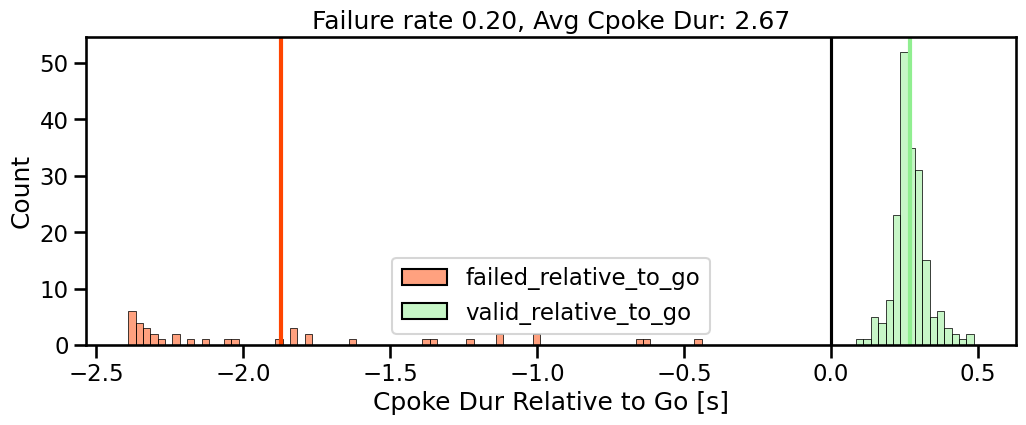

In [5]:
fig, ax = pu.make_fig()
plot_cpoke_distributions(trials_df, ax, mode="settling_in")

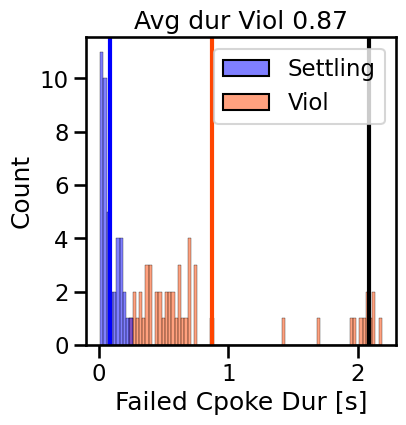

In [23]:
fig, ax = pu.make_fig("s")

plot_avg_failed_cpoke_dur(trials_df, ax, mode="violations")

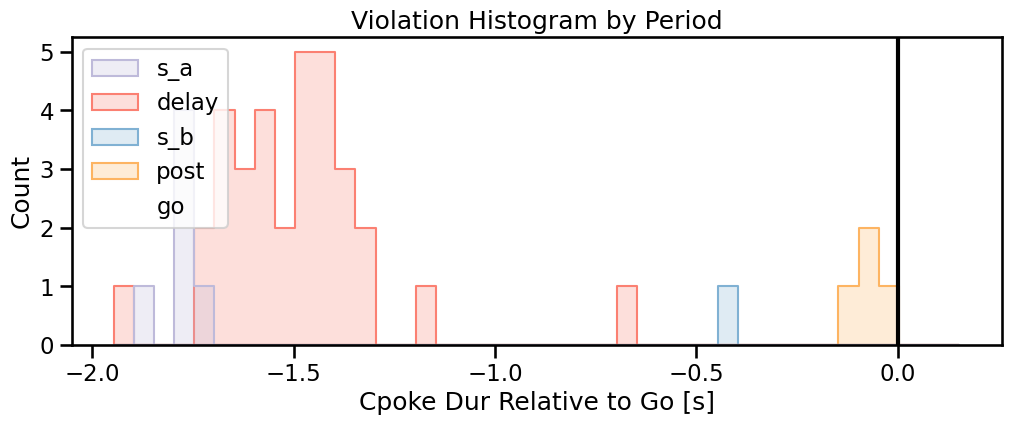

In [44]:
fig, ax = pu.make_fig()
_ = plot_violations_by_period(trials_df, ax)

EXTRA BITS

In [7]:
# plot the viol histogram relative to sa turning on.
# 1. filter for viol trials
# 2. find the time at which sa turned on
# 3. subtract from cpoke dur
# 4. plot histogram

# trials_df = trials_df.query("violations == 1").copy()
# trials_df = trials_df.assign(
#     sa_on_time=trials_df.apply(
#         lambda row: row["settling_in_dur"] + row["settling_in_dur"]
#     )

# trials_df["sa_on_time"] = trials_df["settling_in_dur"] + trials_df["adj_pre_dur"]
# trials_df["sa_off_time"] = sa_on_time + trials_df["stimulus_dur"]
# trials_df["sb_on_time"] = (
#     trials_df["settling_in_dur"]
#     + trials_df["adj_pre_dur"]
#     + trials_df["stimulus_dur"]
#     + trials_df["delay_dur"]
# )
# trials_df["sb_off_time"] = sb_on_time + trials_df["stimulus_dur"]
# viols_df["cpoke_rel_sa_start"] = viols_df.cpoke_dur - viols_df.sa_on_time
# viols_df["cpoke_rel_sa_end"] = viols_df.cpoke_dur - viols_df.sa_off_time
# viols_df["cpoke_rel_sb_start"] = viols_df.cpoke_dur - viols_df.sb_on_time
# viols_df["cpoke_rel_sb_end"] = viols_df.cpoke_dur - viols_df.sb_off_time

In [8]:
# columns_to_plot = [
#     "date",
#     "settling_in_dur",
#     "adj_pre_dur",
#     "stimulus_dur",
#     "delay_dur",
#     "post_dur",
#     "cpoke_dur",
#     "pre_go_dur",
#     "trial",
#     "violations",
# ]
# viols_df = trials_df[columns_to_plot].query("violations == 1")
# viols_df.insert(5, "s_b", viols_df["stimulus_dur"])
# viols_df.rename(columns={"stimulus_dur": "s_a"}, inplace=True)
# viols_df.columns = viols_df.columns.str.replace("_dur", "")
# # Calculate relative period times
# periods = [
#     "settling_in",
#     "adj_pre",
#     "s_a",
#     "delay",
#     "s_b",
#     "post",
# ]
# elapsed_time = 0
# for period in periods:
#     # if period == "settling_in":
#     viols_df[period + "_end"] = elapsed_time + viols_df[period]
#     elapsed_time = viols_df[period + "_end"].values


# def determine_period(row):
#     for period in periods:
#         if row["cpoke"] <= row[period + "_end"]:
#             return period
#     return "go"


# viols_df["violation_period"] = viols_df.apply(determine_period, axis=1)
# viols_df["cpoke"] = viols_df.cpoke - viols_df.pre_go

something really weird is going on- i looking at trial 23 on 08-04 and other trials. they should be violations, yet somehow the cpoke_dur is off. I don't understand how!

In [81]:
locs = [11, 22, 46, 47, 49, 61]  # where viol timing is off

In [79]:
viols_df.violation_period.isnull()

1      False
2      False
3      False
4      False
6      False
7      False
9      False
11      True
17     False
18     False
19     False
21     False
22      True
23     False
25     False
26     False
30     False
31     False
32     False
35     False
38     False
42     False
43     False
44     False
45     False
46      True
47      True
49      True
53     False
61      True
86     False
94     False
95     False
99     False
109    False
110    False
128    False
143    False
148    False
163    False
166    False
167    False
171    False
172    False
186    False
188    False
194    False
195    False
205    False
207    False
Name: violation_period, dtype: bool